# Group 12 - HUM-274: Milestone 3

In [1]:
from math import fabs
from itertools import product
from enum import Enum
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 3)
import scipy.io.wavfile
import numpy as np
from numpy.fft import rfftfreq, irfft
from numpy.random import normal
from IPython.display import Audio
import random
from scipy.io.wavfile import *
import librosa
from librosa import display
from music21 import midi, note, stream, instrument, meter, key, tempo, chord, duration
from music21 import duration as dur
from music21.note import Rest
import platform
from copy import deepcopy
from music21 import converter

platform_str = "\\" if platform.platform()[:7] == "Windows" else "/"


def play(score):
    # shortcut to play a music21 stream
    midi.realtime.StreamPlayer(score).play()


def translate(int_note, durat):
    """
    Given an integer value of a note, get a corresponding music21.note object
    :param int_note: integer value of the note
    :param durat: duration of desired note - if negative, interpret as rest
    :return music21.note
    """
    first_char_arr = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
    pitch = first_char_arr[int_note % 12] + str(int(2 + int_note / 12))

    if durat < 0:
        return note.Rest(duration=duration.Duration(quarterLength=-durat))
    return note.Note(pitch, duration=duration.Duration(quarterLength=durat))

## **All of the code can also be read on Github : [link to our repositery](https://github.com/Dicedead/HUM274).**

The code is more readable there, and it will be much easier for you to generate subsections for yourself if you wish to do so.

*Some cells in this notebook require additional media, given in the media folder of the repositery.*

# I) Brownian noise

To create Gaussian noise, we first started with the idea to create a series of many sine waves, each represented each by numpy arrays with a certain number of values per second (using the Nyquist rate of the upper limit human hearing range). These sine waves would then be rescaled according to the specific type of Gaussian noise required. Unsurprisingly in retrospect, this proved several orders of magnitude too costly to compute.

The solution was to actually start in the frequency domain, have a vector values to sample the human hearing range, rescaling them depending on the required sound colour (e.g. 1/frequency for pink noise), then simply using an inverse Fourier transform to go back to the time domain. This method bypasses the calculation of nearly 20,000 sine waves, each of a very large size (44100), and replaces it by a single computation on an array of size `44100 * required duration` followed by an inverse Fourier transform.

C:\Users\diced\Anaconda3\envs\algo\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\diced\Anaconda3\envs\algo\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
C:\Users\diced\Anaconda3\envs\algo\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linscaley' parameter of __init__() has been renamed 'linscale' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


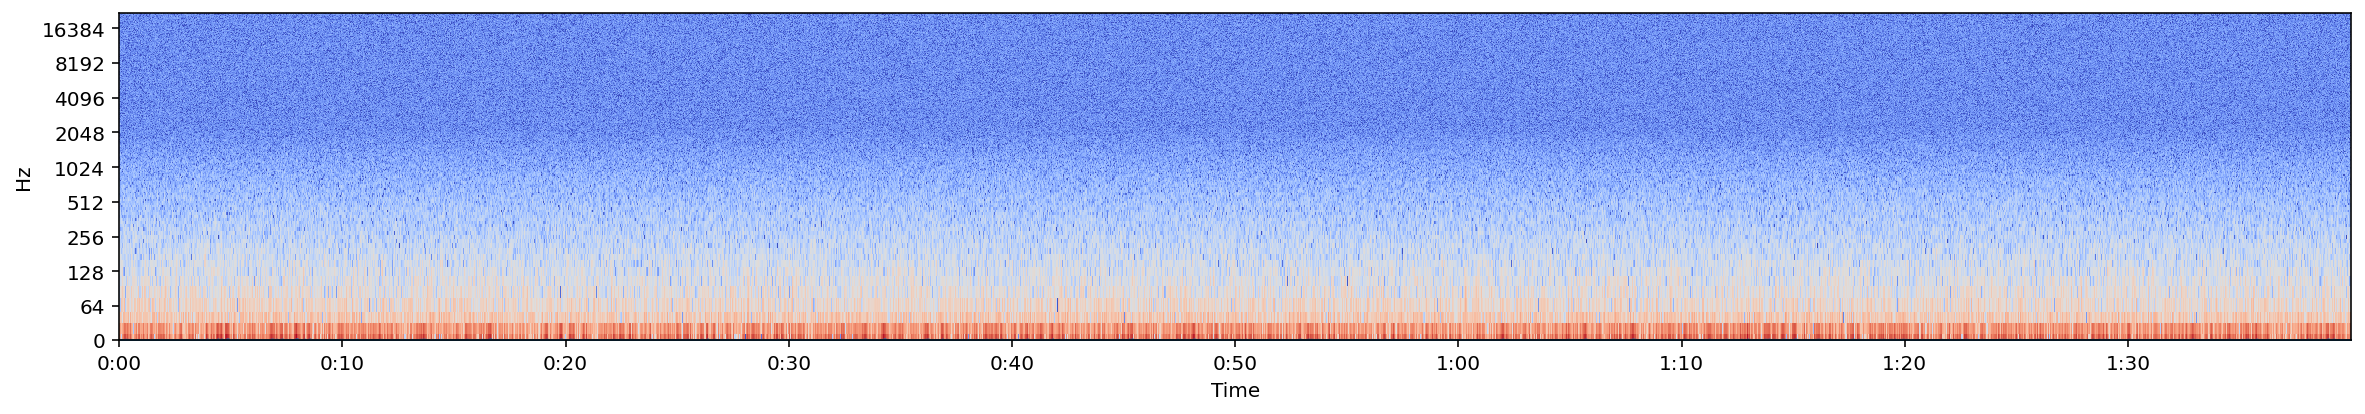

In [2]:
# Using the Nyquist-Shannon theorem
FRAMERATE = 44100

def play_sound(wave, framerate=FRAMERATE):
    # Plays a sound wave expressed as an array of values
    return Audio(wave, rate=framerate, autoplay=True)


def show_spectrogram(wave):
    # Shows spectrogram of input wave
    X = librosa.stft(wave)
    Xdb = librosa.amplitude_to_db(abs(X))
    librosa.display.specshow(Xdb, sr=FRAMERATE, x_axis='time', y_axis='log')


def gaussian_noise(power, duration=1, framerate=FRAMERATE, min_frequency=20, max_frequency=20000):
    """
    Method to create gaussian noise inspired by https://github.com/felixpatzelt/colorednoise, the algorithm comes from :
    On generating power law noise. by Timmer and Koenig
    Astron. Astrophys (1995)

    :param power: power to which to elevate the frequencies of the form 1/(f^power) (0 -> white noise, 1 -> pink noise, 2 -> brown noise)
    :param duration: duration in seconds of the sample to create
    :param framerate: number of sample per second
    :param min_frequency: minimum frequency possible in the output, here set as the minimum frequency of the human hearing spectrum
    :param max_frequency: maximum frequency possible in the output, here set as the maximum frequency of the human hearing spectrum
    :return: a numpy array of length duration * framerate representing the sound value at each frame
    """
    # total number of frames in the output
    length = duration * framerate

    # generating sample frequencies in the Fourier domain
    sample_frequencies = rfftfreq(length)

    # frequency is in hertz = 1/s => the order is reversed for time periods
    min_period = 1 / float(max_frequency)
    max_period = 1 / float(min_frequency)

    # cutting of the array of frequencies at the minimum frequency
    nb_low_period = np.sum(sample_frequencies < min_period)
    if 0 < nb_low_period < len(sample_frequencies):
        sample_frequencies[:nb_low_period] = sample_frequencies[nb_low_period]

    # cutting of the array of frequencies at the minimum frequency
    nb_high_period = np.sum(sample_frequencies > max_period)
    if 0 < nb_high_period < len(sample_frequencies):
        index = len(sample_frequencies) - nb_high_period
        sample_frequencies[index:] = sample_frequencies[index - 1]

    # scaling factors
    scaling_factors = sample_frequencies ** (-power / 2.0)

    # Generating scaled random power + phase
    scaled_power = normal(scale=scaling_factors, size=np.array([len(sample_frequencies)]))
    scaled_phase = normal(scale=scaling_factors, size=np.array([len(sample_frequencies)]))

    # Combining power and phase
    signal = scaled_power + 1J * scaled_phase

    # Using the inverse Fourier transform to go back to the time domain
    output = irfft(signal, n=length, axis=-1)

    return output

if __name__ == "__main__":

    # not chosen as it doesn't induce the wanted effect on the listener, isn't calming and grounding as an exposition
    # should be and nearly sounds distracting
    white_noise = gaussian_noise(0, duration=10)
    play_sound(white_noise)

    # for similar reasons to white noise, we didn't choose pink_noise as it still isn't very pleasant to listen to
    pink_noise = gaussian_noise(1, duration=10)
    play_sound(pink_noise)

    # we chose to work with brown noise as it is much "smoother", nearly holding some reminiscence of the
    # sound of waves, and works well as a calm eposition
    brown_noise = gaussian_noise(2, duration=100)
    play_sound(brown_noise)

    # on the brown noise's spectrogram, we can see the decay in the associated power as the frequency increases
    show_spectrogram(brown_noise)

    # wave plot of the brown noise
    librosa.display.waveplot(brown_noise, sr=FRAMERATE)

    # we divide by 2 to reduce the amplitude of the waves (the traduction to a wav file sometimes struggled if the waves
    # had too big an amplitude), the file saving is commented out (the file is already in the media folder)

    # write(f"media{platform_str}brown_noise.wav", FRAMERATE, brown_noise / 2.0)

Code for the metrical structure:

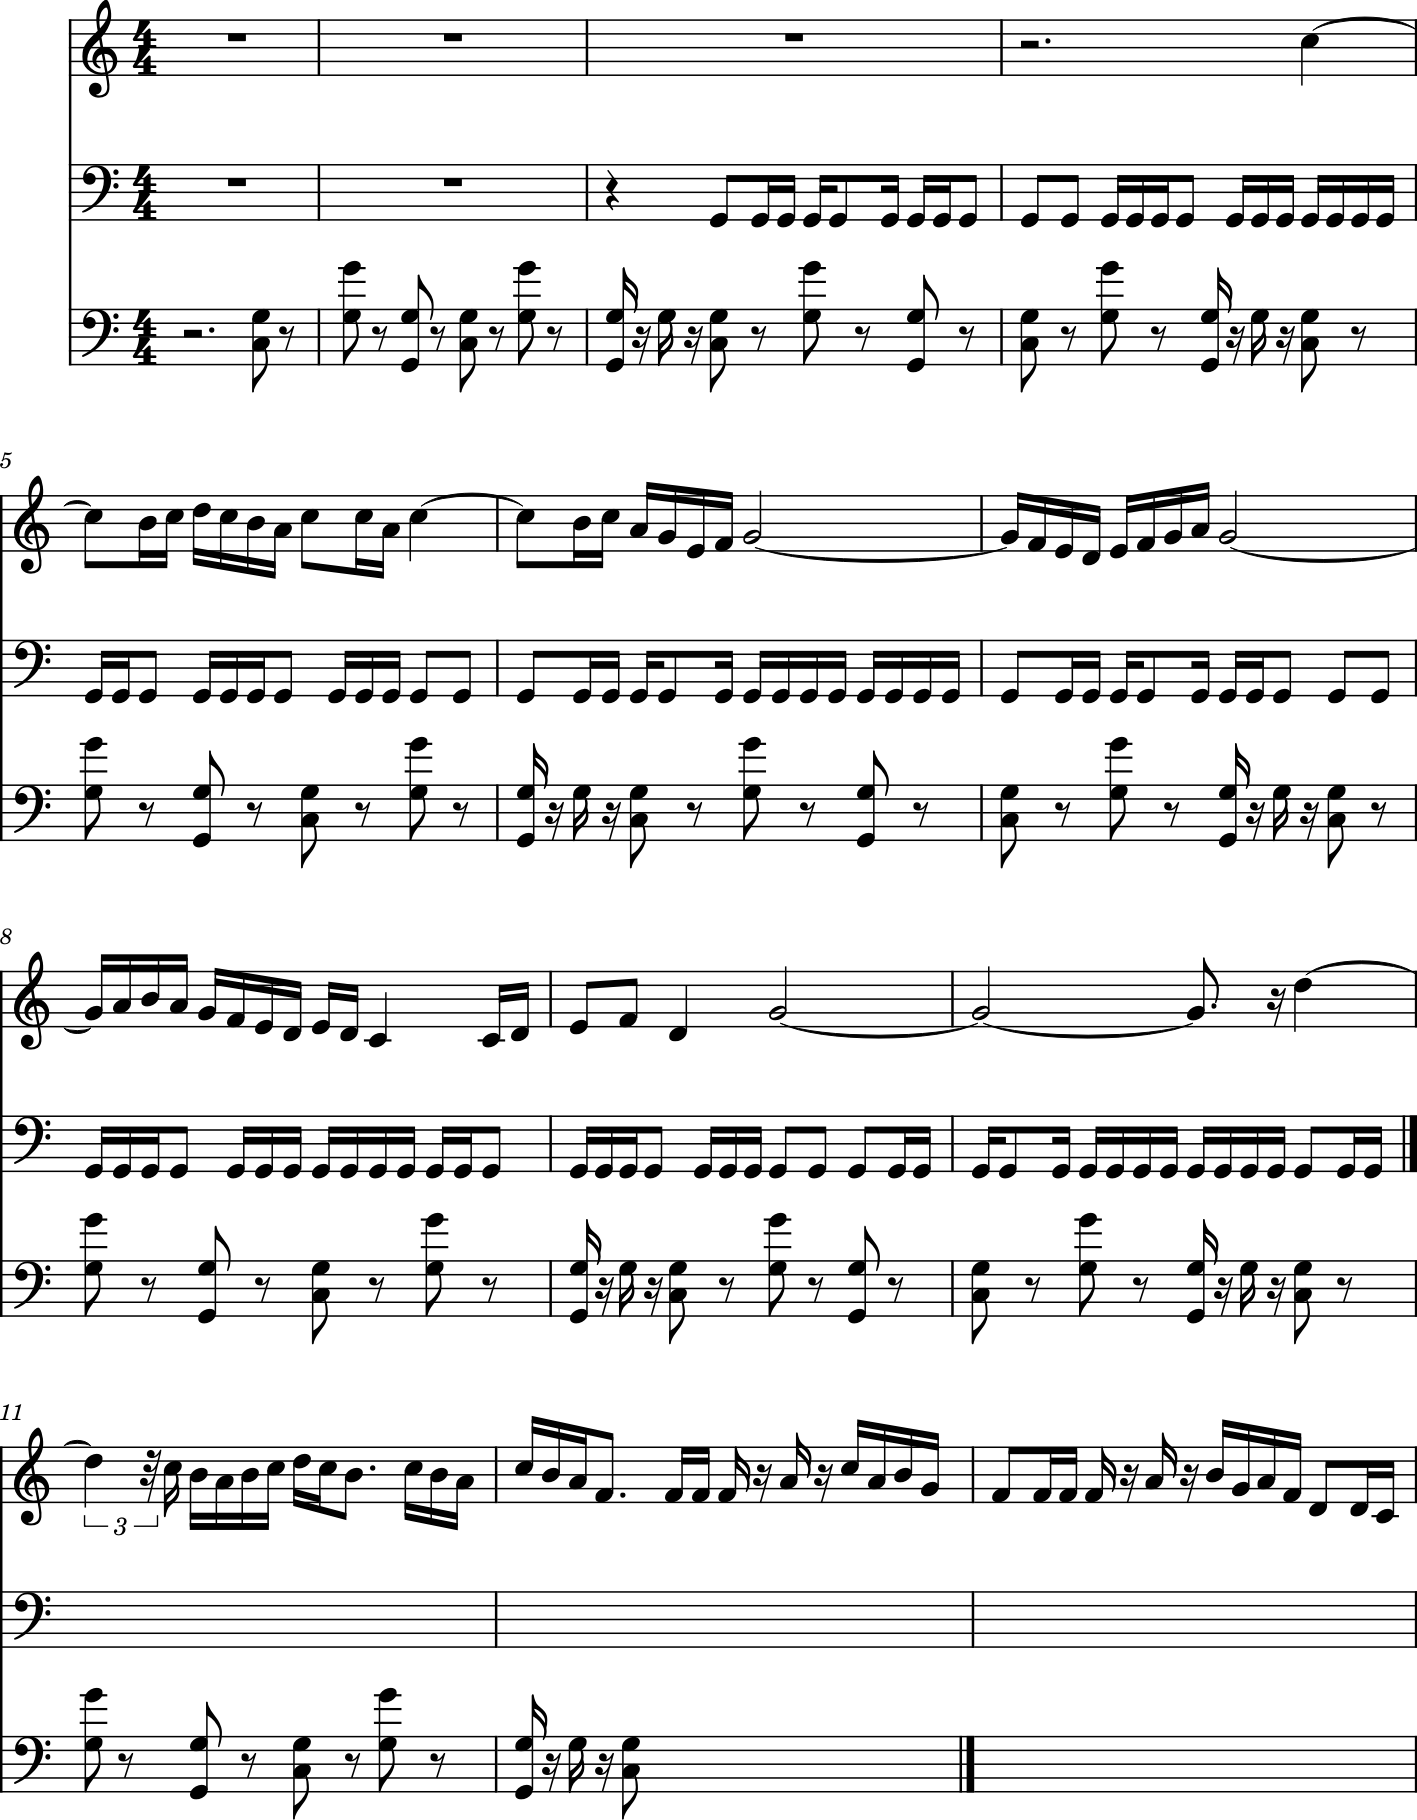

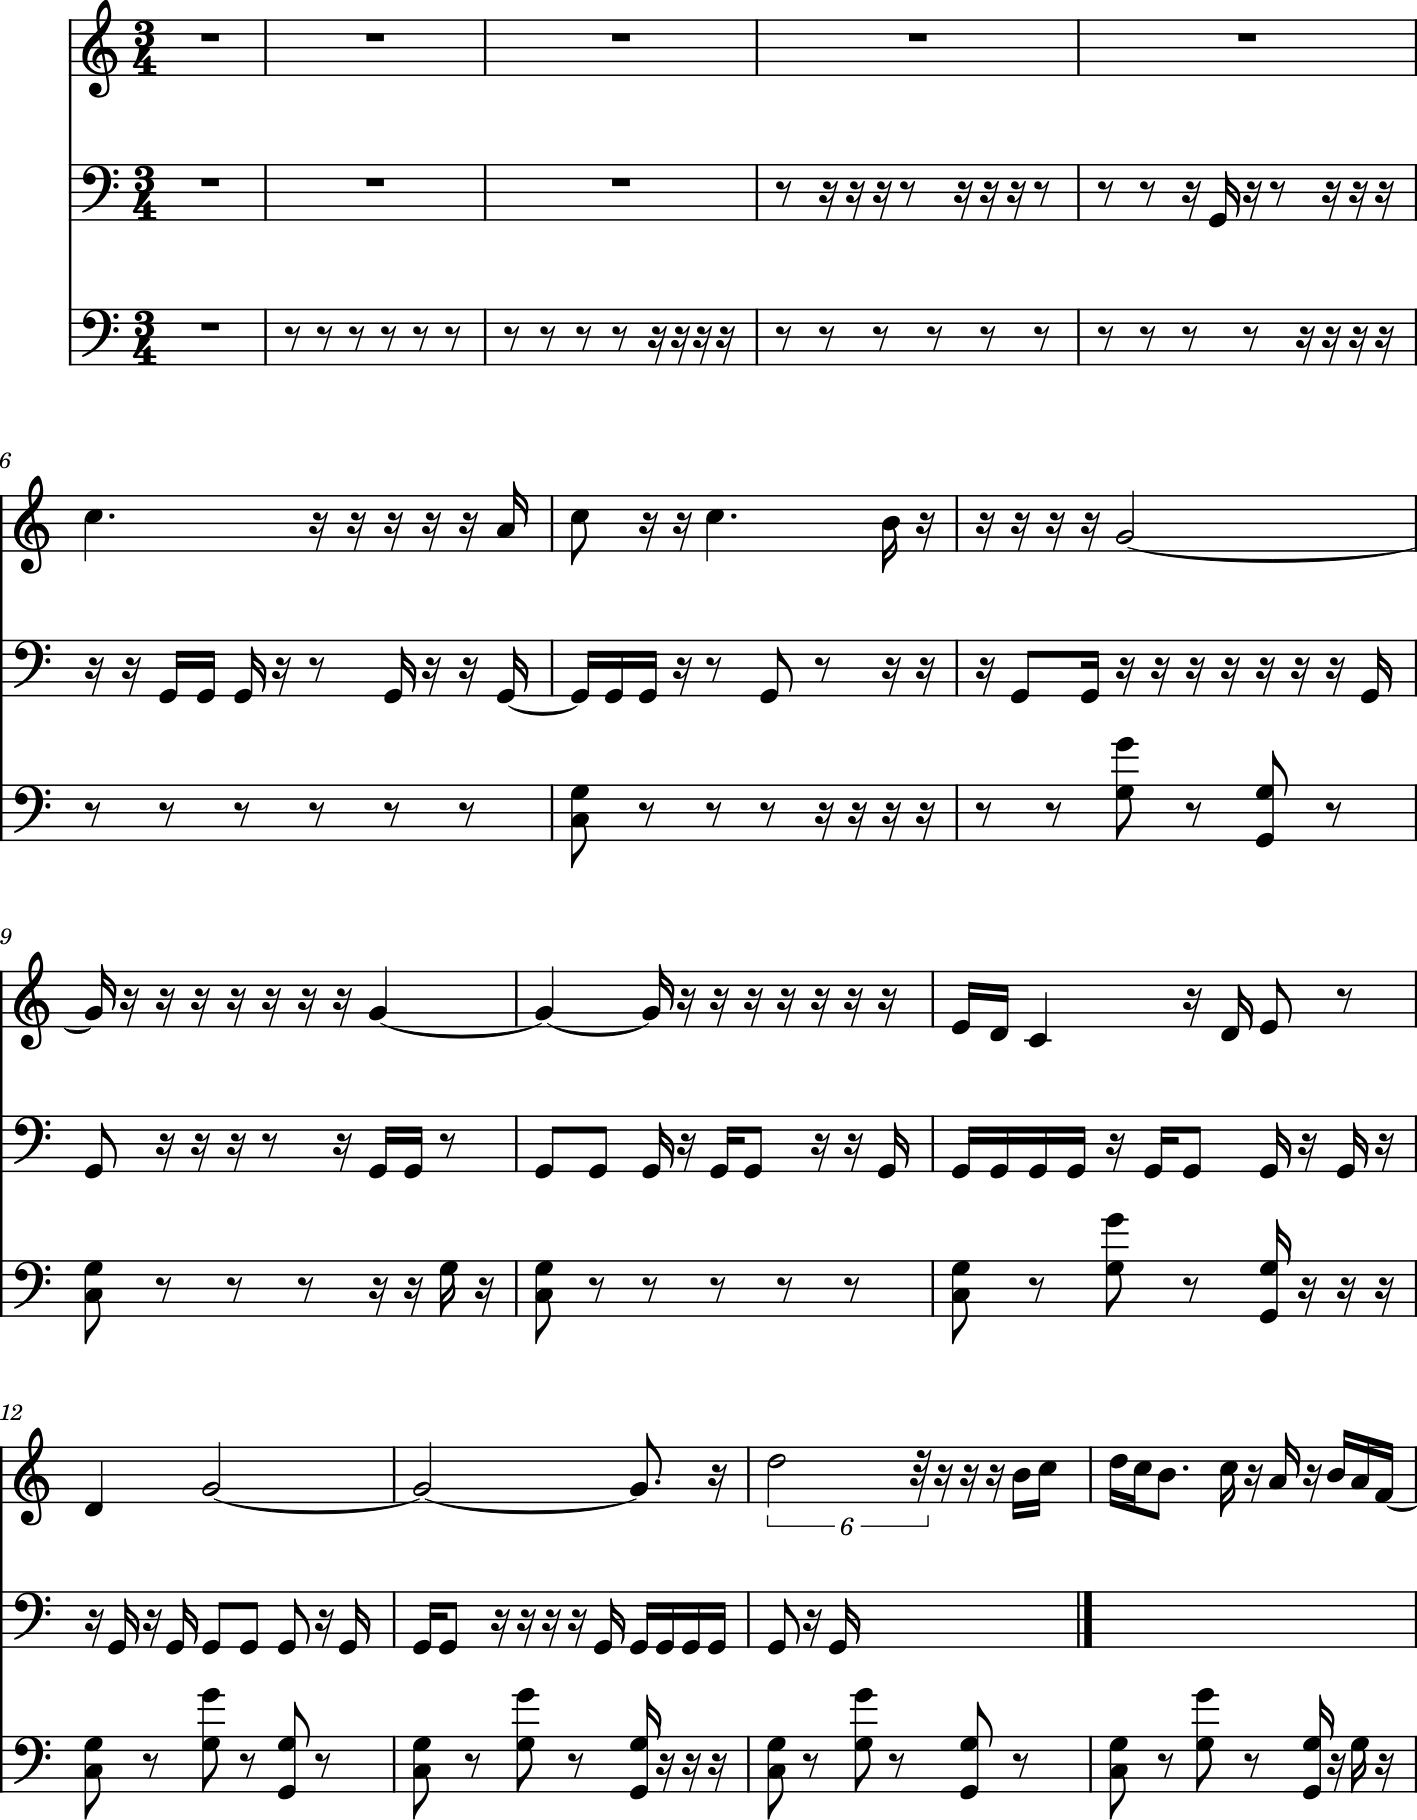

pygame 2.0.1 (SDL 2.0.14, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [4]:
def intro_metrical_structure(s):
    """
    Introduces the melodic theme (here of the Bolero) by gradually adding notes following the metrical structure
    :param s:
    :return: the new stream created
    """
    # stream to accumulate the midi parts
    new_stream = stream.Stream()

    # time sig and tempo
    ts = meter.TimeSignature('3/4')
    new_stream.append(tempo.MetronomeMark(number=72))
    new_stream.insert(0, ts)

    # an instrument to play our score
    new_stream.insert(0, instrument.Guitar())

    # probabilities for each of the beats of the measure to be added (metrical structure)
    initial_probabilities = np.array([3, 1, 2, 1, 2, 1], dtype='float32') / 10

    # looping over the different parts of the score
    for parts in s:
        for part in parts:

            # accumulator for the duration of the notes encountered
            durat = 0

            # creating a part with the right Time signature
            new_part = stream.Part()
            new_part.insert(0, ts)

            # reseting the probabilities for each part
            probabilities = deepcopy(initial_probabilities)

            # on each note or rest
            for element in part.flat.notesAndRests[0:100]:

                # increasing the probabilities once each two measures to create a sense
                # of convergence (the melody begins to make sense)
                elem_duration = element.duration.quarterLength
                if durat + elem_duration >= 6:
                    probabilities *= 1.6

                # getting the new accumulated duration
                durat = (durat + elem_duration) % 6

                # adding the current note with a particular probability
                # or substituting it by a rest of same duration
                if random.random() < probabilities[int(durat)] * elem_duration:
                    new_part.append(element)
                else:
                    r = note.Rest()
                    r.duration = element.duration
                    new_part.append(r)

            # inserting the part
            new_stream.insert(0, new_part)
    return new_stream


# showing (a part of) the original partition before using the intro_metrical_structures (to compare)
def show_original(s):
    original = stream.Stream()
    for parts in s:
        for part in parts:
            new_part = stream.Part()
            for element in part.flat.notesAndRests[0:100]:
                new_part.append(element)
            original.insert(0, new_part)
    original.show()

if __name__ == "__main__":
    # opening our midi file and putting it on a stream
    mf = midi.MidiFile()
    mf.open(f"media{platform_str}Bolero-Ravel_Flute_Bat_Strings.mid")
    mf.read()
    s = stream.Stream()
    s.append(midi.translate.midiFileToStream(mf))
    mf.close()
    show_original(s)

    # the new partition in which we gradually add more and more notes from the original partition
    new_stream = intro_metrical_structure(s)
    new_stream.show()

    # play(new_stream)

Code to assemble the midi file for this exposition part :

In [5]:
# opening our midi file and putting it on a stream
mf = midi.MidiFile()
mf.open(f"media{platform_str}Bolero-Ravel_Flute_Bat_Strings.mid")
mf.read()
s = stream.Stream()
s.append(midi.translate.midiFileToStream(mf))
mf.close()


# II) Brownian motion

The number of levels a quarter note gives us its relative probability, probability which we increase more and more during the iterations.

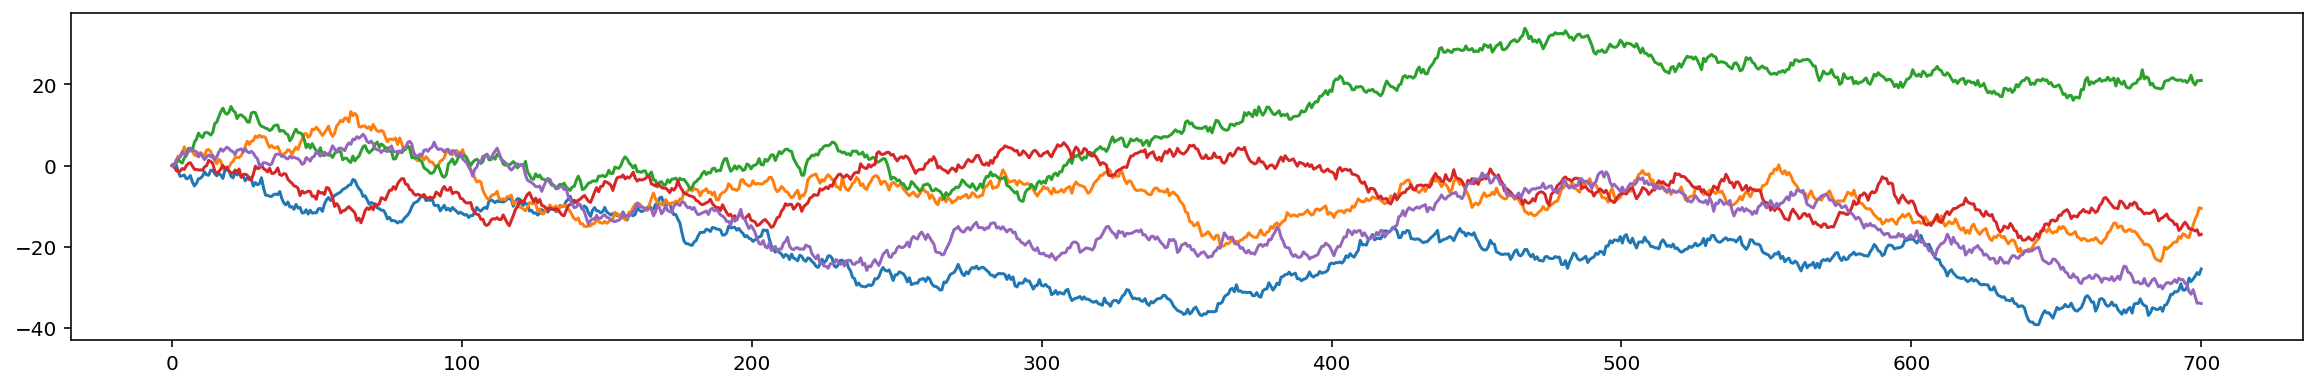

In [6]:
# simulating brownian motion from t=0 to t=TIME_HORIZON
TIME_HORIZON = 700.0
# number of sample points for the simulation
TIMESTEPS = 1000

def brownian_motion(dimensions=1, start_value=0, time_horizon=TIME_HORIZON, timesteps=TIMESTEPS):
    """
    function to simulate brownian motion

    :param dimensions: number of dimensions in which we simulate
    :param start_value: value at which the brownian motion starts
    :param time_horizon: time until which we simulate
    :param timesteps: number of sample points with which to simulate
    :return: a tuple of the different time points at which we simulate, the actual brownian
        motion values at these time points as well as the difference between any 2 points in
        the brownian motion values (as it is more practical to work with)
    """

    # partitioning the space into timesteps number of points
    times = np.linspace(0.0, time_horizon, timesteps)
    step_length = times[1] - times[0]

    # as brownian motion at time t1 - brownian motion at time t0 ~ Normal(mean = 0, variance = t1-t0)
    # scale is the standard deviation, so we take the square root of the step_length
    diff_b = np.random.normal(size=(timesteps - 1, dimensions), scale=np.sqrt(step_length))

    brownian_motion = np.zeros(shape=(timesteps, dimensions))

    # we start each brownian motion dimension with the given start value
    brownian_motion[0, :] = np.full((1, dimensions), start_value)

    # the rest of the values of brownian motion are the cumulative sum of normal values
    brownian_motion[1:, :] = np.cumsum(diff_b, axis=0) + start_value

    return times, brownian_motion, diff_b


if __name__ == "__main__":
    times, brownian_motion_arr, diff_brownian_motion = brownian_motion(dimensions=5)
    plt.plot(times, brownian_motion_arr)
    plt.show()

Code for generating the deconstruction in the disruption element :

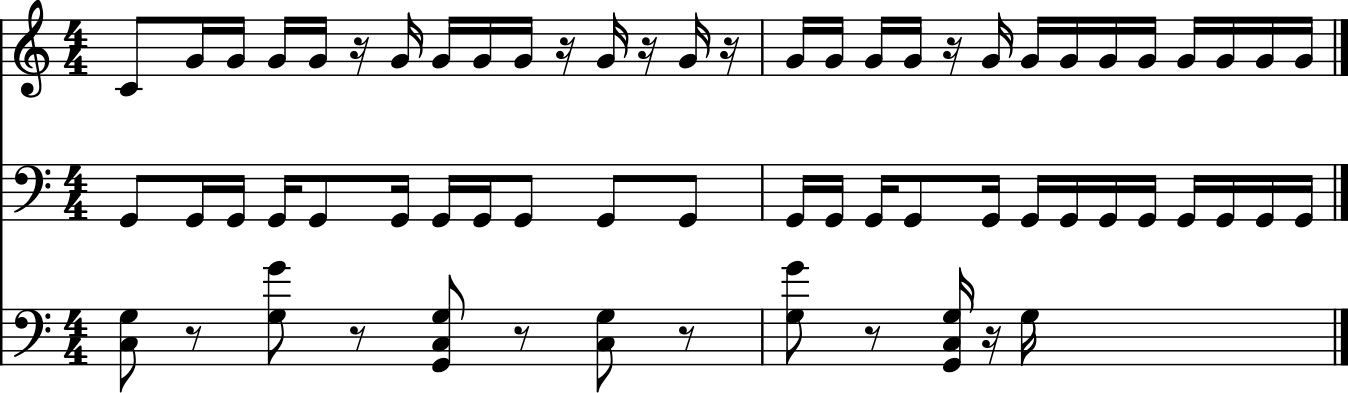

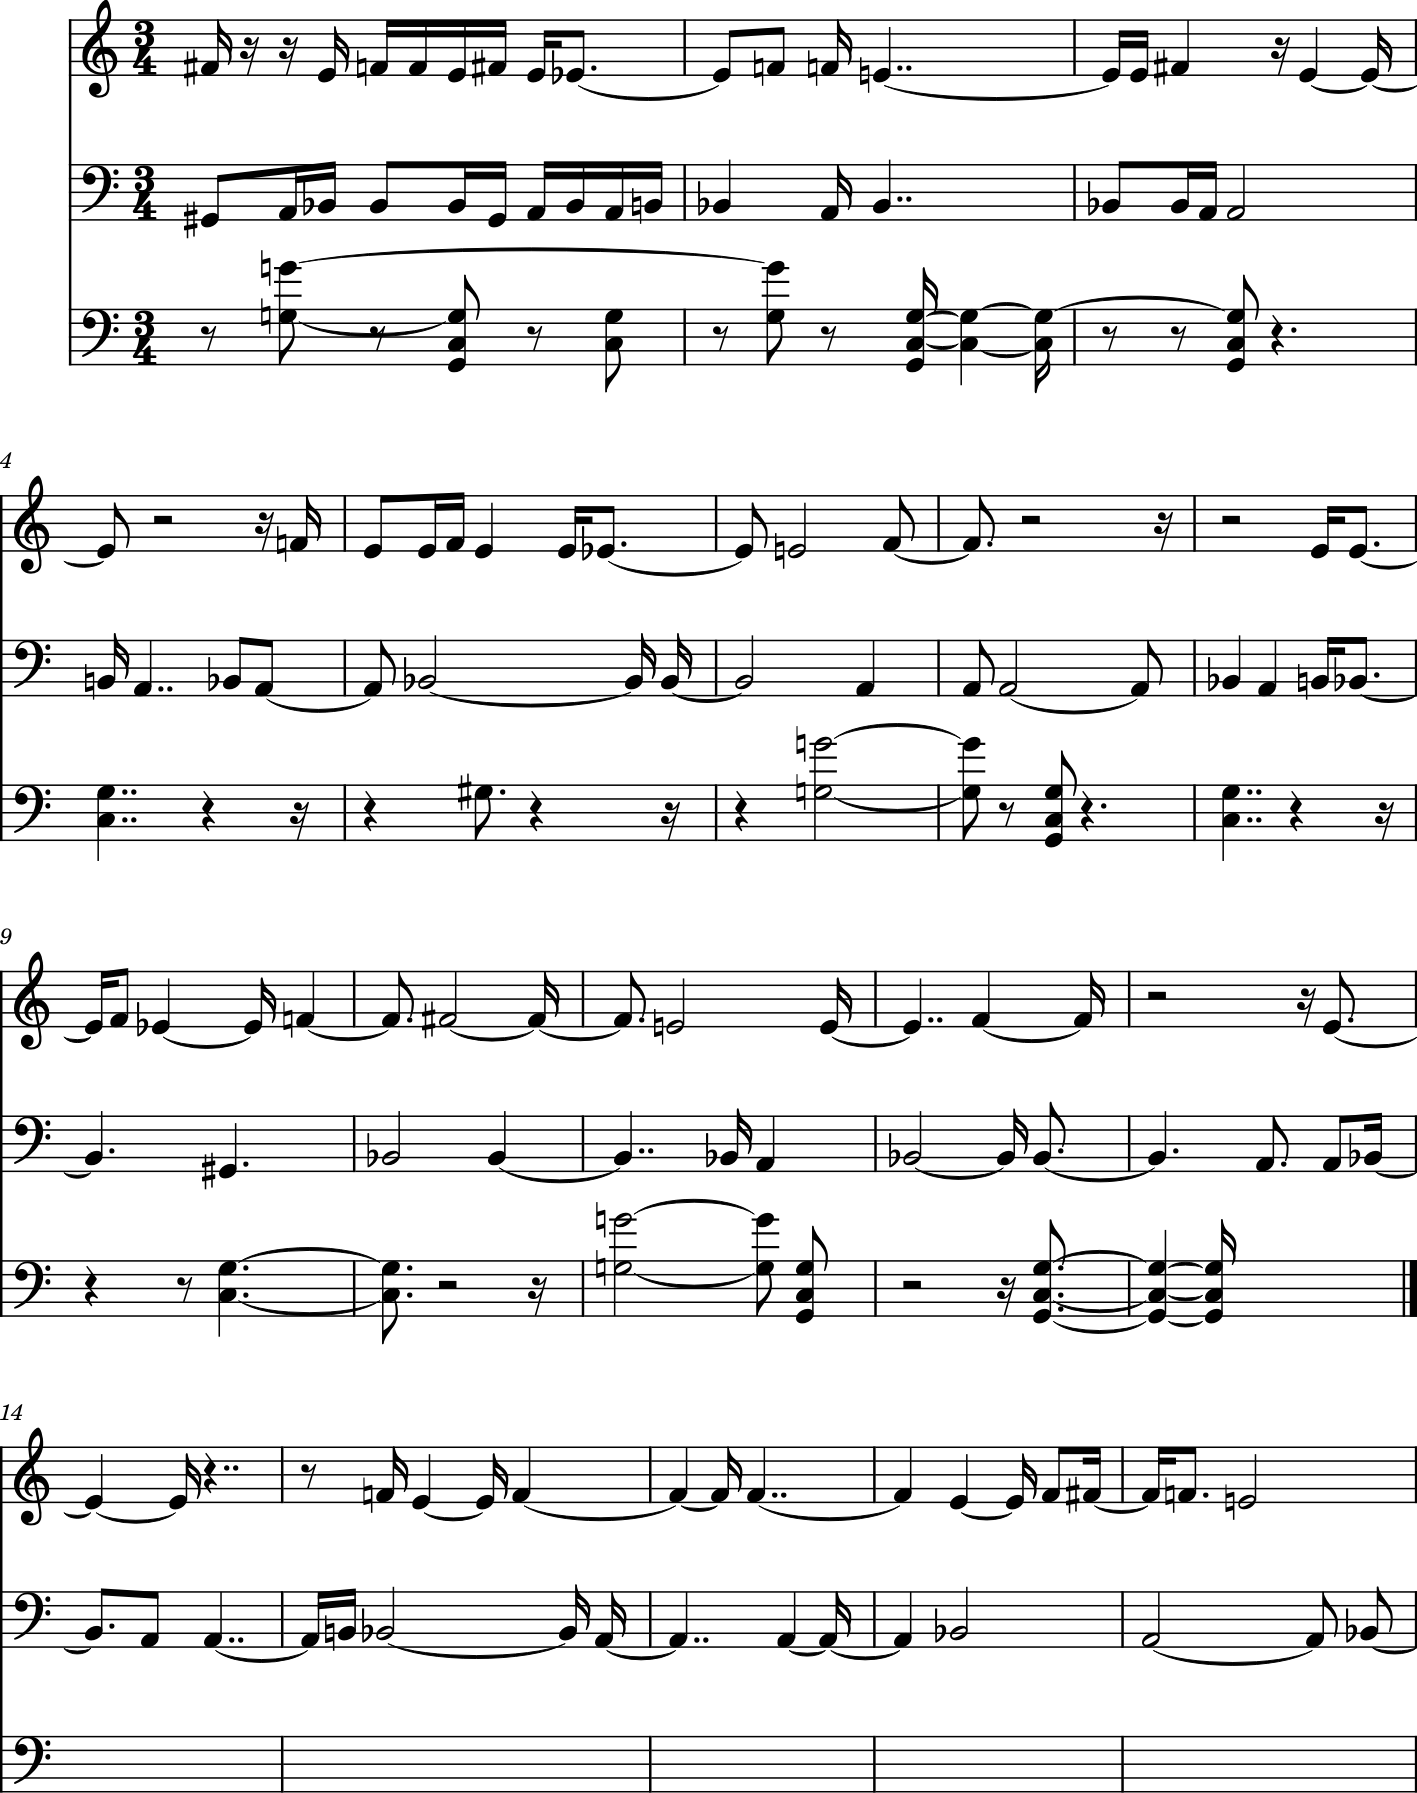

In [8]:
# opening our midi file and putting it on a stream
mf = midi.MidiFile()
mf.open(f"media{platform_str}Bolero-Ravel_Loop.mid")
mf.read()
s1 = stream.Stream()
s1.append(midi.translate.midiFileToStream(mf))
mf.close()

# Note to which we converge : E4
E_PITCH = 64


def transition_to_chaos(s1):
    """
    Takes a stream and makes it "transition to chaos"

    :param s: stream in which to introduce chaotic elements
    :convergence_note: note onto which to slowly converge
    :return:
    """
    # stream to accumulate the midi parts
    new_stream1 = stream.Stream()

    # time sig and tempo
    ts = meter.TimeSignature('3/4')
    new_stream1.append(tempo.MetronomeMark(number=72))
    new_stream1.insert(0, ts)

    # an instrument to play our score
    new_stream1.insert(0, instrument.Guitar())

    # getting the arrays of brownian motion (we create one dimension of brownian motion per track in the midi file)
    _, _, diff_brownian_motion = brownian_motion(dimensions=len(mf.tracks))

    # looping over the different parts
    for parts in s1:
        # and getting the corresponding brownian motion array (one per track/part)
        for part, single_brownian_motion in zip(parts, diff_brownian_motion.transpose()):

            # creating a part with the right Time signature
            new_part = stream.Part()
            new_part.insert(0, ts)

            # to shift the array on each iteration
            index = 0

            # looping five times on the same two measures
            for _ in range(5):
                for element in part.flat.notesAndRests:

                    # shifting the array
                    move = single_brownian_motion[index]
                    index += 1

                    # if the brownian motion goes up and the length is smaller than two (the length of a half-note)
                    # we increase the duration of the element so as to slowly remove rythmic values,
                    # all notes starting to play longer until the length of a half-note
                    elem_duration = element.duration.quarterLength
                    if (elem_duration < 2 and move >= 0):

                        new_elem_duration = round((elem_duration + move) * 4) / 4
                        element.duration = dur.Duration(quarterLength=new_elem_duration)

                    # if the brownian motion is more than -1, we add the element
                    # otherwise it is removed to make the listener lose their balence by violently and
                    # sporadically simplifying the rythm
                    elif move >= -1:

                        # if the element is a chord, no new modifications occur, we add it
                        if element.isClassOrSubclass((chord.Chord,)):
                            c = chord.Chord(element.notes, duration=element.duration)
                            new_part.append(c)
                        else:

                            # if the element is a rest, no new modifications occur, we add it
                            if element.name == 'rest':
                                r = note.Rest(duration=element.duration)
                                new_part.append(r)
                            else:

                                # if element is a note, we shift it's pitch towards E4 (convergence note)
                                elem_pitch = element.pitch.midi
                                to_add = 0
                                if elem_pitch < E_PITCH:
                                    to_add = 1
                                elif elem_pitch > E_PITCH:
                                    to_add = -1

                                element.pitch.midi = elem_pitch + to_add
                                n = note.Note(duration=element.duration, pitch=element.pitch)
                                new_part.append(n)

            # inserting the part
            new_stream1.insert(0, new_part)

    return new_stream1


if __name__ == "__main__":
    # Original score to compare with the new chaotic one
    show_original(s1)

    # Score after the introduction of chaotic elements
    stream_copy = stream.Stream(s1)
    new_stream1 = transition_to_chaos(stream_copy)
    new_stream1.show()

    # play(new_stream1)

# III) Harmonisation
We decided to do the implementation from scratch, i.e. not to use ``music21`` library elements as notes or chords,
because we preferred to have an absolute control over the data structures and achieve code efficiency and simplicity.

First, we have some constants and then parameters that we can change in order to have different outcomes (and also
for debugging...). After that, we create the utilities for the keys and we create the principal data structures for
our implementation: chords and trees of chords.

More details and clarifications about the implementation are included in the code. We have defined some functions,
the main ones are: ``filter_w_rules`` (which applies all the harmonic rules), ``next_chords`` (that computes all the
possible next chords from a given one and a bass note) and ``compose`` (which recursively calls ``next_chords`` and
fills the chord tree).

In summary, all that code takes as input a bass line and a starting chord and creates a tree of all the possibilities
of that harmonisation exercise (a figured bass). Once that code is executed, the following cell defines a method for
choosing one composition among all possibilities, and the third cell represents the starting parameters and general
calls to the functions. The last two little cells show the resulting scores.


For the sake of simplicity, we will restrict ourselves to a simple harmonisation, with some assumptions:

Each note of the bass line represents its corresponding grade in the key, hence each chord is in fundamental state,
i.e. there are no inversions.
The chords are only formed with fifths, i.e., we do not use seventh or ninth chords.

In [11]:
from enum import Enum

###########################################
#               CONSTANTS                 #
###########################################

# NOTES IN THE DIATONIC SCALE
DO = 0
DO_S_RE_F = 1
RE = 2
RE_S_MI_F = 3
MI = 4
FA = 5
FA_S_SOL_F = 6
SOL = 7
SOL_S_LA_F = 8
LA = 9
LA_S_SI_F = 10
SI = 11

# Map from a note (integer) to its corresponding string.
noteOf = {DO: "Do",
          DO_S_RE_F: "Do#/Reb",
          RE: "Re",
          RE_S_MI_F: "Re#/Mib",
          MI: "Mi",
          FA: "Fa",
          FA_S_SOL_F: "Fa#/Solb",
          SOL: "Sol",
          SOL_S_LA_F: "Sol#/Lab",
          LA: "La",
          LA_S_SI_F: "La#/Sib",
          SI: "Si"}

# SCALE DEGREES 0-BASED
TONIC = 0
SUPERTONIC = 1
MEDIANT = 2
SUBDOMINANT = 3
DOMINANT = 4
SUBMEDIANT = 5
LEADING_TONE = 6

# INTERVALS AND ITS CORRESPONDING AMOUNT OF SEMITONES
UNISON = 0
MINOR_THIRD_INTERVAL = 3
MAJOR_THIRD_INTERVAL = 4
PERFECT_FOURTH_INTERVAL = 5
PERFECT_FIFTH_INTERVAL = 7
OCTAVE = 12

###########################################
#          PARAMETERS WE CAN FIT          #
###########################################

EPSILON = 7  # allowed delta between two notes from different adjacent voices when looking for a transition
MAINTAIN_COMMON_NOTES = False  # prioritizes maintaining the common notes when chaining two chords // !!!!!
OVERTAKING_CADENCE = 0  # max. overtaking allowed between two voices when there is a cadence
OVERTAKING_NO_CADENCE = -4  # max. overtaking allowed between two voices when there is not a cadence

RULE_0_ACTIVE = True  # rule 0 : no big overtaking between voices
RULE_1_ACTIVE = True  # rule 1 : no duplication of the leading note
RULE_2_ACTIVE = True  # rule 2 : chords are in (absolute) range
RULE_3_ACTIVE = True  # rule 3 : leading note goes to tonic if grade is V or VII and the following is I, IV or VI
RULE_4_ACTIVE = True  # rule 4 : a note cannot appear more than 2 times in a chord
RULE_5_ACTIVE = True  # rule 5 : the fifth note has to be repeated for VII degree and cannot be repeated otherwise
RULE_6_ACTIVE = True  # rule 6 : all notes of the chord are present
RULE_7_ACTIVE = True  # rule 7 : third duplication (not I, IV, V) and V -> VI (m - M), VI -> V (m)
RULE_8_ACTIVE = True  # rule 8 : fourth augmented interval not allowed
RULE_9_ACTIVE = True  # rule 9 : two consecutive fourths, fifths and octaves are not allowed
RULE_10_ACTIVE = True  # rule 10 : direct fourths, fifths and octaves are not allowed
RULE_11_ACTIVE = True  # rule 11 : leading note and tonic note in the soprano if it is the final cadence

# NOTE RANGES WHERE BASS, TENOR, ALTO AND SOPRANO CAN BE PLACED
MIN_B = DO
MAX_B = DO + 2 * OCTAVE
MIN_T = SOL
MAX_T = SOL + 2 * OCTAVE
MIN_A = SOL + 1 * OCTAVE
MAX_A = MI + 3 * OCTAVE
MIN_S = DO + 2 * OCTAVE
MAX_S = LA + 3 * OCTAVE


###########################################
#            UTILITIES FOR KEYS           #
###########################################

# Creates a new key with one more sharp from the prev_key.
def new_key_sharp(prev_key):
    return [(note + PERFECT_FIFTH_INTERVAL) % 12 for note in prev_key]


# Creates a new key with one more flat from the prev_key.
def new_key_flat(prev_key):
    return [(note + PERFECT_FOURTH_INTERVAL) % 12 for note in prev_key]


# Returns whether a key is major or not.
def is_major(key_min_maj):
    return abs(key_min_maj[MEDIANT] - key_min_maj[TONIC]) == MAJOR_THIRD_INTERVAL


# Enum type which represents keys as lists. From 7 flats to 7 sharps.
class Key(Enum):
    DO_MAJOR = [DO, RE, MI, FA, SOL, LA, SI]
    LA_MINOR = [LA, SI, DO, RE, MI, FA, SOL_S_LA_F]

    # KEYS WITH SHARP :

    SOL_MAJOR = new_key_sharp(DO_MAJOR)
    MI_MINOR = new_key_sharp(LA_MINOR)

    RE_MAJOR = new_key_sharp(SOL_MAJOR)
    SI_MINOR = new_key_sharp(MI_MINOR)

    LA_MAJOR = new_key_sharp(RE_MAJOR)
    FA_S_MINOR = new_key_sharp(SI_MINOR)

    MI_MAJOR = new_key_sharp(LA_MAJOR)
    DO_S_MINOR = new_key_sharp(FA_S_MINOR)

    SI_MAJOR = new_key_sharp(MI_MAJOR)
    SOL_S_MINOR = new_key_sharp(DO_S_MINOR)

    FA_S_MAJOR = new_key_sharp(SI_MAJOR)
    RE_S_MINOR = new_key_sharp(SOL_S_MINOR)

    DO_S_MAJOR = new_key_sharp(FA_S_MAJOR)
    LA_S_MINOR = new_key_sharp(RE_S_MINOR)

    # KEYS WITH FLAT :

    FA_MAJOR = new_key_flat(DO_MAJOR)
    RE_MINOR = new_key_flat(LA_MINOR)

    SI_F_MAJOR = new_key_flat(FA_MAJOR)
    SOL_MINOR = new_key_flat(RE_MINOR)

    MI_F_MAJOR = new_key_flat(SI_F_MAJOR)
    DO_MINOR = new_key_flat(SOL_MINOR)

    LA_F_MAJOR = new_key_flat(MI_F_MAJOR)
    FA_MINOR = new_key_flat(DO_MINOR)

    RE_F_MAJOR = new_key_flat(LA_F_MAJOR)
    SI_F_MINOR = new_key_flat(FA_MINOR)

    SOL_F_MAJOR = new_key_flat(RE_F_MAJOR)
    MI_F_MINOR = new_key_flat(SI_F_MINOR)

    DO_F_MAJOR = new_key_flat(SOL_F_MAJOR)
    LA_F_MINOR = new_key_flat(MI_F_MINOR)

    FA_F_MAJOR = new_key_flat(DO_F_MAJOR)
    RE_F_MINOR = new_key_flat(LA_F_MINOR)

###########################################
#             DATA STRUCTURES             #
###########################################

# Class that represents a chord of three notes which are in the range 0 to 11 (both included).
class SimplifiedChord:
    def __init__(self, fundamental: int, third: int, fifth: int):
        self.fundamental = fundamental % 12
        self.third = third % 12
        self.fifth = fifth % 12

    # Determines whether the (simplified) given note is included in the chord
    def includes(self, note: int):
        new_note = note % 12
        return self.fundamental == new_note or self.third == new_note or self.fifth == new_note


# Class which represents a chord of four notes. The voices are, in order, the bass, the tenor, the alto and the soprano.
class Chord:
    def __init__(self, b: int, t: int, a: int, s: int):
        self.b = b
        self.t = t
        self.a = a
        self.s = s

    # Returns a Chord from a tuple.
    @staticmethod
    def of_tuple(notes):
        if len(notes) == 4:
            return Chord(notes[0], notes[1], notes[2], notes[3])
        else:
            return Chord.empty()

    # Returns the empty Chord.
    @staticmethod
    def empty():
        return Chord(-1, -1, -1, -1)

    # Creates a new Chord with notes in range 0 - 11 and ordered.
    def simplify(self):
        reduced = [self.b % 12, self.t % 12, self.a % 12, self.s % 12]
        return sorted(list({i for i in reduced}))

    # Returns the fundamental of the Chord.
    def fundamental(self):
        return self.b

    # Determines whether the Chord contains the note or not.
    def includes(self, note: int):
        return self.b == note or self.t == note or self.a == note or self.s == note

    # Transforms a Chord into its equivalent list.
    def to_list(self):
        return [self.b, self.t, self.a, self.s]

    # Creates a Chord from a list.
    @staticmethod
    def of(chord_list):
        if len(chord_list) == 4:
            return Chord(chord_list[0], chord_list[1], chord_list[2], chord_list[3])
        else:
            return Chord.empty()

    # Checks whether the notes respect the voice range constraints or not.
    def check_abs_ranges(self):
        abs_range_b = MIN_B <= self.b <= MAX_B
        abs_range_t = MIN_T <= self.t <= MAX_T
        abs_range_a = MIN_A <= self.a <= MAX_A
        abs_range_s = MIN_S <= self.s <= MAX_S

        return abs_range_b and abs_range_t and abs_range_a and abs_range_s

    # Checks if the number of semitones between adjacent voices is correct.
    def check_inter_ranges(self):
        return (abs(self.s - self.a) <= 14) and (abs(self.a - self.t) <= 14) and (abs(self.t - self.b) <= 24)

    # Check if the ranges of the voices are correct from their absolute and inter ranges.
    def check_ranges(self):
        return self.check_abs_ranges() and self.check_inter_ranges()

    # Creates a new SimplifiedChord from a fundamental note and a key.
    @staticmethod
    def simple_of(fundamental: int, key_simple: list):
        new_fundamental = fundamental % 12
        ind_fund = key_simple.index(new_fundamental)
        return SimplifiedChord(key_simple[ind_fund], key_simple[(ind_fund + 2) % 7],
                               key_simple[(ind_fund + 4) % 7])

    def __eq__(self, that):
        if isinstance(that, Chord):
            return self.b == that.b and self.t == that.t and self.a == that.a and self.s == that.s
        else:
            return False

    def __hash__(self):
        return hash((self.b, self.t, self.a, self.s))

    def __str__(self):
        return "Chord (b:{}, t:{}, a:{}, s:{})".format(self.b, self.t, self.a, self.s)


# Class which represents a tree of Chord.
class ChordTree:
    def __init__(self, root: Chord, depth: int):
        self.root = root
        self.depth = depth

    def __str__(self):
        return "\t" * (self.depth - 1) + str(self.root) + " (" + str(self.depth) + ")" + "\n"


# Class that represents a leaf (a form of ChordTree).
# The leaf is formed of a root and has a depth (within its parent ChordTree).
class Leaf(ChordTree):

    def __init__(self, root: Chord, depth: int):
        super().__init__(root, depth)

    # Returns a 1 level as it is a leaf.
    def level(self):
        return 1

    # Returns its total depth within its parent ChordTree.
    def total_depth(self):
        return self.depth

    def __str__(self):
        notes = noteOf[self.root.b % 12] + ", " + noteOf[self.root.t % 12] + ", " \
                + noteOf[self.root.a % 12] + ", " + noteOf[self.root.s % 12]

        return "\t" * (self.depth - 1) + str(self.root) + " (" + notes + ")" + " (" + str(self.depth) + ")" + "\n"


# Class that represents a node (a form of ChordTree). It has a root, a depth (within its parent ChordTree)
# and a list of children (of type ChordTree).
class Node(ChordTree):

    def __init__(self, root: Chord, depth: int, children: list):
        super().__init__(root, depth)
        self.children = children

    # Adds a child to the node.
    def add_child(self, child):
        self.children.append(child)

    # Adds a list of children to the node.
    def add_children(self, children):
        self.children.extend(children)

    # Returns the total number of leaves the node contains as a ChordTree.
    def level(self):
        children_count = 0
        for child in self.children:
            children_count += child.level()
        return children_count

    # Returns the largest total depth of its children as a ChordTree.
    def total_depth(self):
        max_depth = 1
        for child in self.children:
            child_total_depth = child.total_depth()
            if child_total_depth > max_depth:
                max_depth = child_total_depth
        return max_depth

    def __str__(self):
        notes = noteOf[self.root.b % 12] + ", " + noteOf[self.root.t % 12] + ", " \
                + noteOf[self.root.a % 12] + ", " + noteOf[self.root.s % 12]
        ret = "\t" * (self.depth - 1) + str(self.root) + " (" + notes + ")" + " (" + str(self.depth) + ")" + "\n"

        for child in self.children:
            ret += str(child)
        return ret


# Class that represents a empty node (a form of ChordTree). It has a depth (within its parent ChordTree).
class Empty(ChordTree):
    def __init__(self, depth: int):
        super().__init__(Chord.empty(), depth)

    def __str__(self):
        print("Empty")


###########################################
#          HARMONISATION METHODS          #
###########################################

def all_options(simple_options):
    """
    Auxiliary method which returns the cartesian product of chords (as lists) for all the simple_options.
    :param simple_options: a list which contains lists of possible elements for each voice
    :return: the set containing all the combinations of the elements of simple_options
    """
    return {i for i in product(*simple_options)}


def all_in_epsilon(note):
    """
    Auxiliary method that returns a range (of notes) within the epsilon value.
    :param note: the "central" note
    :return: the range of note
    """
    return range(max(0, note - EPSILON), note + EPSILON + 1)


def complete_transition(current_chord_list, next_chord_list, next_simple_chord: SimplifiedChord):
    """
    Auxiliary method that completes and returns all the possible transitions between the current chord
    and the sketch of the next chord.
    For the notes of the next_chord that are not defined, it creates a list with all the possible values.
    After that, it computes and returns all the different possibilities of chords.

    :param current_chord_list: the current chord, of type list
    :param next_chord_list: the sketch of the next chord, of type list
    :param next_simple_chord: the next chord in simplified format
    :return:a set of all the possible next chords
    """
    simple_options = []

    for i, note in enumerate(next_chord_list):

        if note == -1:
            # Adds the list for the notes within the range and filters it by the notes included in the next chord
            simple_options.append(list(filter(lambda x: next_simple_chord.includes(x),
                                              list(all_in_epsilon(current_chord_list[i])))))
        else:
            simple_options.append([note])  # the note is already defined

    return all_options(simple_options)  # computes all the options from the simple list (of length 4) of lists


def filter_w_rules(current_chord_list, options, next_next_degree, is_final_cadence, key_rules_input):
    """
    This method sequentially filters the set of all possible options following the more important harmonic rules.
    The different rules can be deactivated independently thanks to the corresponding constants.

    :param current_chord_list: the list that represents the current chord
    :param options: the set of all the possible chords for the next chord
    :param next_next_degree: the note that represents the degree two positions ahead, -1 if there is not
    :param is_final_cadence: boolean that determines if the next_chord is the final chord of a cadence
    :param key_rules_input: the key
    :return: set of the filtered options
    """
    key_degrees = key_rules_input.value

    # The temporary set that changes with respect to the rules
    temp = options.copy()
    ##############################################
    # RULE 0 : NO BIG OVERTAKING BETWEEN VOICES
    temp0 = set()
    for next_chord in temp:

        # Intervals between adjacent voices
        b_t_interval = next_chord[1] - next_chord[0]
        t_a_interval = next_chord[2] - next_chord[1]
        a_s_interval = next_chord[3] - next_chord[2]

        # The allowed overtaking between voices depends on whether there is a cadence or not
        not_big_overtake_b_t = b_t_interval >= OVERTAKING_NO_CADENCE if is_final_cadence else b_t_interval >= OVERTAKING_CADENCE
        not_big_overtake_t_a = t_a_interval >= OVERTAKING_NO_CADENCE if is_final_cadence else t_a_interval >= OVERTAKING_CADENCE
        not_big_overtake_a_s = a_s_interval >= OVERTAKING_NO_CADENCE if is_final_cadence else a_s_interval >= OVERTAKING_CADENCE

        if not_big_overtake_b_t and not_big_overtake_t_a and not_big_overtake_a_s:
            temp0.add(next_chord)
    temp = temp0 if RULE_0_ACTIVE else temp

    ##############################################
    # RULE 1 : NO DUPLICATION OF THE LEADING NOTE
    temp1 = set()
    for next_chord in temp:
        ack = 0
        for note in next_chord:
            if note % 12 == key_degrees[LEADING_TONE]:
                ack += 1
        if 0 <= ack < 2:
            temp1.add(next_chord)
    temp = temp1 if RULE_1_ACTIVE else temp

    ##############################################
    # RULE 2 : CHORDS RESPECT CORRECT RANGES
    temp2 = set()
    for next_chord in temp:
        if Chord.of_tuple(next_chord).check_ranges():
            temp2.add(next_chord)
    temp = temp2 if RULE_2_ACTIVE else temp

    ####################################################################
    # RULE 3 : LEADING NOTE GOES TO TONIC IF CURRENT GRADE IS III, V OR VII
    #          AND THE FOLLOWING IS I, IV OR VI
    temp3 = set()
    for next_chord in temp:

        prev_fund = Chord.simple_of(current_chord_list[0], key_degrees).fundamental
        current_fund = Chord.simple_of(next_chord[0], key_degrees).fundamental

        # Determines whether the leading notes is considered active (need to resolve)
        leading_active = (prev_fund == key_degrees[DOMINANT] or prev_fund == key_degrees[LEADING_TONE] or prev_fund ==
                          key_degrees[MEDIANT]) \
                         and (current_fund == key_degrees[TONIC] or current_fund == key_degrees[SUBDOMINANT]
                              or current_fund == key_degrees[SUBMEDIANT])

        for i, curr_note in enumerate(current_chord_list):
            if not leading_active or \
                    (curr_note % 12 == key_degrees[LEADING_TONE] and next_chord[i] % 12 == key_degrees[TONIC]
                     and leading_active):
                temp3.add(next_chord)
    temp = temp3 if RULE_3_ACTIVE else temp

    ##################################################################
    # RULE 4 : A NOTE CANNOT APPEAR MORE THAT 2 TIMES IN A SAME CHORD
    temp4 = set()
    for next_chord in temp:
        simple_notes_list = list(map(lambda x: x % 12, list(next_chord)))
        correct_dupl = True

        for note in simple_notes_list:
            if simple_notes_list.count(note) > 2:
                correct_dupl = False

        if correct_dupl:
            temp4.add(next_chord)
    temp = temp4 if RULE_4_ACTIVE else temp

    #############################################################################################
    # RULE 5 : THE FIFTH NOTE HAS TO BE REPEATED FOR VII DEGREE AND CANNOT BE REPEATED OTHERWISE
    temp5 = set()
    for next_chord in temp:
        fund = Chord.simple_of(next_chord[0], key_degrees).fundamental
        fifth = Chord.simple_of(next_chord[0], key_degrees).fifth
        simple_notes_list = list(map(lambda x: x % 12, list(next_chord)))

        if fund % 12 == key_degrees[LEADING_TONE]:
            if simple_notes_list.count(fifth) == 2:
                temp5.add(next_chord)
        elif simple_notes_list.count(fifth) < 2:
            temp5.add(next_chord)
    temp = temp5 if RULE_5_ACTIVE else temp

    ##############################################
    # RULE 6 : ALL NOTES OF THE CHORD ARE PRESENT
    temp6 = set()
    for next_chord in temp:
        simple_next_chord = Chord.simple_of(next_chord[0], key_degrees)
        simple_notes_list = list(map(lambda x: x % 12, list(next_chord)))

        if simple_next_chord.fundamental in simple_notes_list and simple_next_chord.third in simple_notes_list \
                and simple_next_chord.fifth in simple_notes_list:
            temp6.add(next_chord)
    temp = temp6 if RULE_6_ACTIVE else temp

    ########################################################################################################
    # RULE 7 : THIRD DUPLICATION IS AUTHORISED WHEN THE DEGREE IS NOT I, IV AND V; AND IS MANDATORY WHEN
    #               V -> VI chaining in major and minor tonalities (3rd duplicated in VI)
    #               VI -> V chaining in minor tonality (3rd duplicated in VI)
    #               VII -> I (already implemented because of the 1st and 5st rules, 3rd dup. in VII)
    temp7 = set()
    for next_chord in temp:
        prev_fund = Chord.simple_of(current_chord_list[0], key_degrees).fundamental
        next_fund = Chord.simple_of(next_chord[0], key_degrees).fundamental
        third = Chord.simple_of(next_chord[0], key_degrees).third
        simple_notes_list = list(map(lambda x: x % 12, list(next_chord)))

        third_two_times = simple_notes_list.count(third) == 2

        # Third duplication not recommended
        third_not_recom = next_fund == key_degrees[TONIC] or next_fund == key_degrees[SUBDOMINANT] \
                          or next_fund == key_degrees[DOMINANT]

        # V -> VI chaining in major and minor tonalities (3rd dup. in VI)
        v_vi = prev_fund == key_degrees[DOMINANT] and next_fund == key_degrees[SUBMEDIANT]

        # VI -> V chaining in minor tonality (3rd dup. in VI)
        vi_v_minor = next_fund == key_degrees[SUBMEDIANT] and \
                     next_next_degree == key_degrees[DOMINANT] and not is_major(key_degrees)

        mandatory_third = v_vi or vi_v_minor

        if (mandatory_third and third_two_times) or (not mandatory_third and not (third_not_recom and third_two_times)):
            temp7.add(next_chord)
    temp = temp7 if RULE_7_ACTIVE else temp

    #################################################
    # RULE 8 : FOURTH AUGMENTED INTERVAL NOT ALLOWED
    temp8 = set()
    for next_chord in temp:

        has_augm_interval = False
        for i, current_note_i in enumerate(current_chord_list):

            # Current note (and next note) are the leading note
            current_note_leading = current_note_i % 12 == key_degrees[LEADING_TONE]
            next_note_leading = next_chord[i] % 12 == key_degrees[LEADING_TONE]

            # Ascending augmented forth interval
            aug_forth_asc = current_note_i % 12 == key_degrees[SUBDOMINANT] and \
                            next_note_leading and \
                            next_chord[i] - current_note_i == 6

            # Descending augmented forth interval
            aug_forth_des = current_note_leading and \
                            next_chord[i] % 12 == key_degrees[SUBDOMINANT] and \
                            current_note_i - next_chord[i] == 6

            # Ascending augmented second interval
            aug_second_asc = current_note_i % 12 == key_degrees[SUBMEDIANT] and \
                             next_note_leading and \
                             next_chord[i] - current_note_i == 3

            # Descending augmented second interval
            aug_second_des = current_note_leading and \
                             next_chord[i] % 12 == key_degrees[SUBDOMINANT] and \
                             current_note_i - next_chord[i] == 3

            # Ascending augmented fifth interval
            aug_fifth_asc = current_note_i % 12 == key_degrees[MEDIANT] and \
                            next_note_leading and \
                            next_chord[i] - current_note_i == 8

            # Descending augmented fifth interval
            aug_fifth_des = current_note_leading and \
                            next_chord[i] % 12 == key_degrees[MEDIANT] and \
                            current_note_i - next_chord[i] == 8

            # If the key is major, augmented intervals can only be fourths
            if is_major(key_degrees):
                if aug_forth_asc or aug_forth_des:
                    has_augm_interval = True

            # If the key is minor, augmented intervals can be fourths, fifths and seconds
            else:
                if aug_forth_asc or aug_forth_des or aug_second_asc or aug_second_des \
                        or aug_fifth_asc or aug_fifth_des:
                    has_augm_interval = True

        if not has_augm_interval:
            temp8.add(next_chord)
    temp = temp8 if RULE_8_ACTIVE else temp

    #########################################################################
    # RULE 9 : TWO CONSECUTIVE FOURTHS, FIFTHS AND OCTAVES ARE NOT ALLOWED
    temp9 = set()
    for next_chord in temp:
        interval_problem = False

        # Compares for the not allowed consecutive intervals between the two chords
        # for all the possible pairs of voices (voice i and a higher voice j)
        for i, note_current_i in enumerate(current_chord_list):
            for j in range(i, 4):
                if i != j:
                    # There is no common note
                    mov = current_chord_list[j] != next_chord[j] or note_current_i != next_chord[i]

                    interval_current = (current_chord_list[j] - note_current_i) % 12
                    interval_next = (next_chord[j] - next_chord[i]) % 12
                    if interval_current == interval_next and mov and \
                            (interval_current == UNISON or interval_current == PERFECT_FOURTH_INTERVAL or
                             interval_current == PERFECT_FIFTH_INTERVAL):
                        interval_problem = True
        if not interval_problem:
            temp9.add(next_chord)
    temp = temp9 if RULE_9_ACTIVE else temp

    #########################################################################
    # RULE 10 : DIRECT FOURTHS, FIFTHS AND OCTAVES ARE NOT ALLOWED
    temp10 = set()
    for next_chord in temp:
        interval_problem = False

        # Compares for the not allowed direct intervals between the two chords
        # for all the possible pairs of voices (voice i and a higher voice j)
        for i, note_current_i in enumerate(current_chord_list):
            for j in range(i, 4):
                if i != j:

                    # An interval is considered direct if both voices change in the same direction
                    # and both for more of a tone
                    interval_next = (next_chord[j] - next_chord[i]) % 12
                    change_chords_i = next_chord[i] - note_current_i
                    change_chords_j = next_chord[j] - current_chord_list[j]

                    if ((change_chords_i > 2 and change_chords_j > 2) or (
                            change_chords_i < -2 and change_chords_j < -2)) \
                            and (interval_next == UNISON or interval_next == PERFECT_FOURTH_INTERVAL
                                 or interval_next == PERFECT_FIFTH_INTERVAL):
                        interval_problem = True

        if not interval_problem:
            temp10.add(next_chord)
    temp = temp10 if RULE_10_ACTIVE else temp

    ###################################################################################
    # RULE 11 : LEADING NOTE AND TONIC NOTE IN THE SOPRANO IF IT IS THE FINAL CADENCE
    temp11 = set()
    if (not is_final_cadence) or current_chord_list[0] % 12 == key_degrees[LEADING_TONE]:
        temp11 = temp10
    else:
        for next_chord in temp:
            if current_chord_list[3] % 12 == key_degrees[LEADING_TONE] and next_chord[3] % 12 == key_degrees[TONIC]:
                temp11.add(next_chord)
    temp = temp11 if RULE_11_ACTIVE else temp

    return temp


# Dictionary that includes transitions from a chord and a the next bass note to all the possible next chords
transition = {}


def next_chords(current_chord: Chord, next_note: int, next_next_note: int, is_final_cadence: bool, key_for_chords: Key):
    """
    Computes all the possible next chords for the next note

    :param current_chord: the current chord
    :param next_note: the next note from the bass to chain
    :param next_next_note: the following note of the next note
    :param is_final_cadence: boolean that indicates if it is the final cadence
    :param key_for_chords: the key of the harmonization
    :return: the set of all the possible next_chords for the next note
    """
    global transition

    options = transition.get((current_chord, next_note))

    # If the transition is already computed, it uses it and does not again the computation (dynamic programming)
    if options is not None and not is_final_cadence:
        return options

    else:
        options = set()

        current_chord_list = current_chord.to_list()
        # Already copies the bass note
        next_chord_list = [next_note]
        next_simple_chord = Chord.simple_of(next_note, key_for_chords.value)

        # If the constant MAINTAIN_COMMON_NOTES is true, we keep the common notes in the following chord if possible
        # For the undetermined notes, it adds -1
        if MAINTAIN_COMMON_NOTES:
            if current_chord.fundamental() == next_note:
                options.add(tuple(current_chord.to_list()))
            else:
                for note in current_chord_list[1:]:
                    if next_simple_chord.includes(note) and note % 12 != key_for_chords.value[LEADING_TONE]:
                        next_chord_list.append(note)
                    else:
                        next_chord_list.append(-1)
        else:
            next_chord_list = [next_note, -1, -1, -1]

        # Computes of the possible options for the next chord thanks to the filter_w_rules method
        options = filter_w_rules(current_chord_list,
                                 complete_transition(current_chord_list, next_chord_list, next_simple_chord),
                                 next_next_note,
                                 is_final_cadence,
                                 key_for_chords)

        if is_final_cadence:
            # Adds the current transition to the global dictionary
            transition[(current_chord, next_note)] = tuple(opt for opt in options)
            return transition[(current_chord, next_note)]
        else:
            return tuple(opt for opt in options)


def compose(initial_chord, bass_line, prev_chord_tree, prev_cadence, tonality_compose):
    """
    Recursive method that computes algorithmically the composition (computes all the possible harmonizations)
    and inserts it into the tree. A node (or a leaf) of the chord tree keeps track of its previous chord.

    :param initial_chord: initial chord
    :param bass_line: bass line (a list of notes)
    :param prev_chord_tree: the chord tree
    :param prev_cadence: boolean that indicates whether this following chord is the last for the final cadence
    :param tonality_compose: key of the harmonization
    :return: void function, as it stores the results in the tree
    """
    ton_value = tonality_compose.value
    next_cadence = False

    if len(bass_line) > 1:
        if len(bass_line) == 2:
            next_cadence = bass_line[0] % 12 == ton_value[DOMINANT] or bass_line[0] % 12 == ton_value[LEADING_TONE] \
                           or (bass_line[0] % 12 == ton_value[MEDIANT])

        # All the possible next chords from the current chord
        list_next_chords = next_chords(initial_chord, bass_line[0], bass_line[1], prev_cadence, tonality_compose)

        for chord in list_next_chords:
            chord_type = Chord(chord[0], chord[1], chord[2], chord[3])
            node = Node(chord_type, prev_chord_tree.depth + 1, [])
            # Adds the next chord to a node and continues the composition from that chord
            prev_chord_tree.add_child(node)
            compose(chord_type, bass_line[1:], node, next_cadence, tonality_compose)

    elif len(bass_line) == 1:
        # Notifies next_chords that this is the final cadence
        list_next_chords = next_chords(initial_chord, bass_line[0], -1, prev_cadence, tonality_compose)

        for chord in list_next_chords:
            chord_type = Chord(chord[0], chord[1], chord[2], chord[3])
            # As it is the final chord, creates a leaf instead of a node
            leaf = Leaf(chord_type, prev_chord_tree.depth + 1)
            prev_chord_tree.add_child(leaf)

Utilizing the harmonisation cell:

In [12]:
def to_arrays(voices):
    """
    :param voices: list of chords
    """
    bass = []
    tenor = []
    alto = []
    soprano = []

    for tetrad in voices:
        bass.append(tetrad.b)
        tenor.append(tetrad.t)
        alto.append(tetrad.a)
        soprano.append(tetrad.s)

    return [bass, tenor, alto, soprano]


def combine_voices_harm(length: int, *voices, inst=None, time_sig='4/4'):
    """
    Combines the voices with music21 objects.
    :param length: common length of voices to consider
    :param voices: sequences of integers encoding notes
    :param inst: instruments
    :param time_sig: time signature
    :return stream of chords
    """

    voices = voices[0]
    if inst is None:
        inst = [instrument.BrassInstrument() if i % 2 == 0 else instrument.Piano() for i in range(len(voices))]
    score = stream.Score(timeSignature=time_sig)

    parts = [stream.Part() for _ in range(len(voices))]
    for part_index in range(len(voices)):
        for i in range(length):
            parts[part_index].append(translate(voices[part_index][i], 1))

    for i in reversed(range(len(parts))):
        parts[i].insert(0, inst[i])
        score.insert(0, parts[i])

    return score


def select_path_in_tree_harm(length: int, composition_tree: Node):
    """
    From a chord tree, randomly chooses a path (of an expected length)
    :param length: the expected length of the path
    :param composition_tree: the composition tree
    :return: the path
    """
    curr_node = composition_tree
    path = [curr_node.root]

    for i in range(length):

        if isinstance(curr_node, Node):
            list_index = list(range(0, len(curr_node.children)))
            random.shuffle(list_index)

            index = 0
            index_elem = list_index[index]

            while index < len(list_index) - 1 and curr_node.children[index_elem].total_depth() != length:
                index += 1
                index_elem = list_index[index]

            curr_node = curr_node.children[index_elem]
            path.append(curr_node.root)

    return path


Defining initial chords and bass lines, and the method to create a composition:

Chord (b:12, t:28, a:36, s:43) (Do, Mi, Do, Sol) (1)
	Chord (b:17, t:24, a:33, s:41) (Fa, Do, La, Fa) (2)
		Chord (b:11, t:26, a:29, s:41) (Si, Re, Fa, Fa) (3)
			Chord (b:16, t:23, a:31, s:40) (Mi, Si, Sol, Mi) (4)
			Chord (b:16, t:19, a:28, s:35) (Mi, Sol, Mi, Si) (4)
				Chord (b:9, t:24, a:28, s:36) (La, Do, Mi, Do) (5)
				Chord (b:9, t:21, a:28, s:36) (La, La, Mi, Do) (5)
			Chord (b:16, t:31, a:31, s:35) (Mi, Sol, Sol, Si) (4)
			Chord (b:16, t:28, a:31, s:35) (Mi, Mi, Sol, Si) (4)
				Chord (b:9, t:28, a:24, s:36) (La, Mi, Do, Do) (5)
				Chord (b:9, t:28, a:36, s:36) (La, Mi, Do, Do) (5)
				Chord (b:9, t:28, a:33, s:36) (La, Mi, La, Do) (5)
			Chord (b:16, t:19, a:31, s:35) (Mi, Sol, Sol, Si) (4)
		Chord (b:11, t:29, a:38, s:41) (Si, Fa, Re, Fa) (3)
			Chord (b:16, t:28, a:35, s:43) (Mi, Mi, Si, Sol) (4)
			Chord (b:16, t:23, a:31, s:40) (Mi, Si, Sol, Mi) (4)
			Chord (b:16, t:23, a:31, s:43) (Mi, Si, Sol, Sol) (4)
			Chord (b:16, t:31, a:31, s:35) (Mi, Sol, Sol, Si) (4)
			

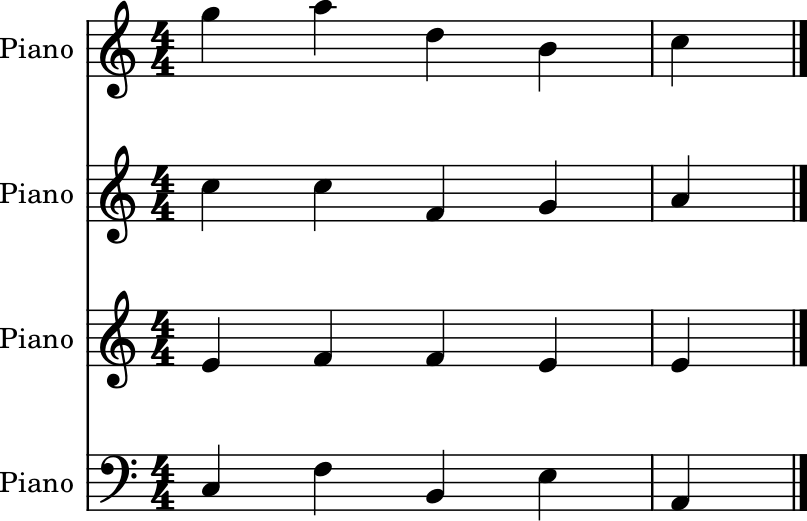

In [15]:
# Do M
start_chord_3 = Chord(DO + OCTAVE, DO + 2 * OCTAVE, SOL + 2 * OCTAVE, MI + 3 * OCTAVE)
bass_3 = [DO, FA, SOL, DO, LA, RE, SOL, SI, DO + OCTAVE]

# Sol M
start_chord_4 = Chord(RE + OCTAVE, LA + 1 * OCTAVE, RE + 2 * OCTAVE, FA_S_SOL_F + 2 * OCTAVE)
bass_4 = [RE, SOL, DO, RE, SOL, DO, RE, SI, MI, SOL, MI]

# Mi m
start_chord_5 = Chord(MI, SI + 1 * OCTAVE, SOL + 2 * OCTAVE, MI + 3 * OCTAVE)
bass_5 = [MI, SI, MI, SOL, FA_S_SOL_F, SI, MI]

# La M
start_chord_6 = Chord(MI, SOL_S_LA_F + 1 * OCTAVE, SI + 1 * OCTAVE, MI + 2 * OCTAVE)
bass_6 = [MI, LA, RE, MI, LA, SOL_S_LA_F, LA, SI, MI, LA, SI]

# Mi M
start_chord_7 = Chord(SI, FA_S_SOL_F + 1 * OCTAVE, RE_S_MI_F + 2 * OCTAVE, SI + 2 * OCTAVE)
bass_7 = [SI, MI, LA, SI, MI, DO_S_RE_F, FA_S_SOL_F, SI, MI, SOL_S_LA_F]

# Do # m
start_chord_8 = Chord(SOL_S_LA_F, RE_S_MI_F + 1 * OCTAVE, DO + 2 * OCTAVE, SOL_S_LA_F + 2 * OCTAVE)
bass_8 = [SOL_S_LA_F, DO_S_RE_F + 1 * OCTAVE, SOL_S_LA_F, DO_S_RE_F + 1 * OCTAVE, RE_S_MI_F + 1 * OCTAVE, DO + 1 * OCTAVE, DO_S_RE_F + 1 * OCTAVE]

# Re b M
start_chord_9 = Chord(DO_S_RE_F + 1 * OCTAVE, FA + 2 * OCTAVE, DO_S_RE_F + 3 * OCTAVE, SOL_S_LA_F + 3 * OCTAVE)
bass_9 = [DO_S_RE_F + 1 * OCTAVE, SOL_S_LA_F, DO_S_RE_F + 1 * OCTAVE, LA_S_SI_F, FA_S_SOL_F, SOL_S_LA_F, LA_S_SI_F, DO_S_RE_F + 1 * OCTAVE, RE_S_MI_F + 1 * OCTAVE]

# La b m
start_chord_10 = Chord(SOL_S_LA_F, DO + 2 * OCTAVE, SOL_S_LA_F + 2 * OCTAVE, RE_S_MI_F + 3 * OCTAVE)
bass_10 = [SOL_S_LA_F, DO_S_RE_F, RE_S_MI_F, SOL_S_LA_F, DO_S_RE_F]

# Do b M
start_chord_11 = Chord(FA_S_SOL_F, DO_S_RE_F + 2 * OCTAVE, LA_S_SI_F + 2 * OCTAVE, FA_S_SOL_F + 3 * OCTAVE)
bass_11 = [SOL_S_LA_F, SI + OCTAVE, MI + OCTAVE]

# Fa b M
start_chord_12 = Chord(MI + OCTAVE, SI + OCTAVE, SOL_S_LA_F + 2 * OCTAVE, MI + 3 * OCTAVE)
bass_12 = [MI, SI + OCTAVE, MI]

# Mi M
start_chord_13 = Chord(MI, SI + OCTAVE, SOL_S_LA_F + 2 * OCTAVE, MI + 3 * OCTAVE)
bass_13 = [MI, LA, SI, MI, SI, MI]

# la m
start_chord_14 = Chord(LA, DO + 2 * OCTAVE, LA + 2 * OCTAVE, MI + 3 * OCTAVE)
bass_14 = [LA, MI, LA, RE + OCTAVE, MI + OCTAVE, LA]

# Do M
start_chord_15 = Chord(DO + OCTAVE, MI + 2 * OCTAVE, DO + 3 * OCTAVE, SOL + 3 * OCTAVE)
bass_15 = [DO + OCTAVE, FA + OCTAVE, SI, MI + OCTAVE, LA]



def create_composition(key, start_chord, bass):
    voices = [[], [], [], []]
    composition_tree = Node(start_chord, 1, [])

    compose(start_chord, bass[1:], composition_tree, False, key)
    print(composition_tree)
    print("composition_tree's level (total number of different compositions) : " + str(composition_tree.level()))

    path = select_path_in_tree_harm(len(bass), composition_tree)
    # path = to_arrays(path)[0:len(path)]
    path = to_arrays(path)
    for i in range(4):
        voices[i].extend(path[i])

    parts = combine_voices_harm(len(voices[0]), voices,
                                inst=[instrument.Piano(), instrument.Piano(), instrument.Piano(), instrument.Piano()])

    # parts.write('midi', f'midi{platform_str}output_final.mid')
    parts.show()
    return parts


def concatenate_midi(midi1, midi2):
    part1 = converter.parse(midi1)
    part2 = converter.parse(midi2)

    for i in range(len(part1)):
        part1[i].append(part2[i])
    return part1


if __name__ == "__main__":
    create_composition(Key.DO_MAJOR, start_chord_15, bass_15)
    # parts = concatenate_midi('midi/121314.mid', 'midi/1516.mid')
    # parts.write('midi', 'midi/12_16.mid')
    # parts.show()

# IV) L-System
Basic L-System implementation:

In [16]:
class Rule:
    """
    Encodes L Systems' replacement rules.
    """

    def __init__(self, base: str, replacement: str):
        """
        :param base: string,
        :param replacement: string
        """
        self.base = base
        self.replacement = replacement


class LSystem:
    """
    L System's functionality.
    """

    def __init__(self, *rules):
        """
        An L System = a set of rules

        :param rules: List[Rule]
        """
        self.rules = {}
        [self.rules.update({rule.base: rule.replacement}) for rule in rules]

    def replace(self, base, show_mode: bool = False):
        """
        The brains of an L System, doing the simple task of applying each rule recursively

        :param base: some base string
        :param show_mode: boolean deciding whether to put separating brackets or not between rule applications
        :return: result of applications of all replacement rules on base string
        """
        new_string = ""
        for c in base:
            if c in self.rules:
                if show_mode:
                    new_string += "<"
                new_string += self.rules.get(c)
                if show_mode:
                    new_string += ">"
            else:
                new_string += c
        return new_string

    def run(self, initial: str, nb_iterations: int, show_mode: bool = False):
        """
        Applies the replace method nb_iterations times with base string initial

        :param initial: first base string
        :param nb_iterations: how many times rules replacements should occur
        :param show_mode: boolean deciding whether to put separating brackets or not between rule applications
        :return: last result of rule applications
        """
        string = initial
        for i in range(nb_iterations):
            string = self.replace(string, show_mode)
        return string

Some L-Systems:

In [17]:
def rules_complex():
    rule_a = Rule("A", "BB[+-D+A")
    rule_b = Rule("B", "D[-C""D[-C")
    rule_c = Rule("C", "CD+C-C-")
    rule_d = Rule("D", "A+[D-DD+D")
    return LSystem(rule_a, rule_b, rule_c, rule_d)


def initial_complex():
    return "A+B"


def run_complex_for(n, show_mode=False):
    return rules_complex().run(initial_complex(), n, show_mode)


def sequence_from_string_complex(string: str):
    """
    To use with chars: A, B, C, D, +, -, [
    A: half note
    B: quarter
    C: eighth
    D: sixteenth
    +: add previous and next duration
    -: make previous note a rest (value: -1 * duration of rest)
    [: extend previous duration by 50%
    :param string: input string
    :return: sequence of durations (floats)
    """

    def char_to_duration(c: str, tb: list):
        if c == 'A':
            tb.append(2)
        elif c == 'B':
            tb.append(1)
        elif c == 'C':
            tb.append(1 / 2)
        elif c == 'D':
            tb.append(3 / 4)
        elif c == '[':
            if len(tb) > 0:
                tb[-1] = tb[-1] + 0.5 * tb[-1]
        elif c == '-':
            if len(tb) > 0:
                tb[-1] = -tb[-1]
        return tb[-1]

    def is_duration_char(c: str):
        return c in ['A', 'B', 'C', 'D']

    str_arr = [c for c in string]
    tab = []
    while not len(str_arr) == 0:
        nb_chars_read = 1

        if str_arr[0] == '+' and len(str_arr) >= 2:
            nb_chars_read = 2
            if len(tab) > 0 and is_duration_char(str_arr[1]):
                old_read = tab[-1]
                new_read = char_to_duration(str_arr[1], tab)
                new_dur = fabs(old_read) + fabs(new_read)
                if old_read < 0:
                    new_dur = -new_dur
                tab[-2] = new_dur
                tab = tab[:-1]

        else:
            char_to_duration(str_arr[0], tab)

        str_arr = str_arr[nb_chars_read:]  # remove chars read
    return tab


def rules_bolero():
    """
    Converge to the Bolero snare drum part: A B A C
    where A = the common first half of the two measures
              (one eighth note + 3 sixteenths)
          B = A + 2 eighth notes, the second half of the
              first measure
          C = A + 6 sixteenth notes, the second half of the
              second measure
    """
    return LSystem(
        Rule("A", "ESSS"),
        Rule("B", "ESSSEE"),
        Rule("C", "ESSSSSSSSSZ"),
        Rule("E", "E"),
        Rule("S", "S"),
        Rule("T", "S"),
        Rule("W", "STSTSTTSSE"),
        Rule("X", "WYTTAYYESSYZ"),
        Rule("Y", "BATTWBWTTTTSTTA"),
        Rule("Z", "ABAC")
    )


def initial_bolero():
    return "YWWX"


def run_bolero_for(n, show_mode=False):
    return rules_bolero().run(initial_bolero(), n, show_mode)


def sequence_from_string_bolero(string: str):
    """
    To use with chars in chars_bolero
    Notes with rhythmical values:

    E: eight note
    S: sixteenth note
    T: 32nd note

    A: triplet
    B: two triplets
    C: dotted eight note

    W: quarter note rest
    X: quintuplet
    Y: two quintuplets
    Z: eight note rest

    :param string: input string
    :return: sequence of durations (floats)
    """
    note_durations = {
        "E": 1 / 2,
        "S": 1 / 4,
        "T": 1 / 8,

        "A": 1 / 3,
        "B": 2 / 3,
        "C": 3 / 4,

        "W": -1 / 4,
        "X": 1 / 5,
        "Y": 2 / 5,
        "Z": -1 / 2
    }

    return [note_durations.get(c) for c in string]


def rules_slow():
    rule_a = Rule("A", "BB[+-D+A")
    rule_b = Rule("B", "D[-""D[-")
    rule_d = Rule("D", "A+[D-DD+D")
    return LSystem(rule_a, rule_b, rule_d)


def initial_slow():
    return "A+B"


def run_slow_for(n, show_mode=False):
    return rules_complex().run(initial_complex(), n, show_mode)


def sequence_from_string_slow(string: str):
    """
    To use with chars: A, B, D, -, [
    A: half note
    B: quarter
    D: dotted eighth
    +: add previous and next duration
    -: make previous note a rest (value: -1 * duration of rest)
    [: extend previous duration by 50%
    :param string: input string
    :return: sequence of durations (floats)
    """

    def char_to_duration(c: str, tb: list):
        if c == 'A':
            tb.append(2)
        elif c == 'B':
            tb.append(1)
        elif c == 'D':
            tb.append(3 / 4)
        elif c == '[':
            if len(tb) > 0:
                tb[-1] = tb[-1] + 0.5 * tb[-1]
        elif c == '-':
            if len(tb) > 0:
                tb[-1] = -tb[-1]
        return tb[-1]

    str_arr = [c for c in string]
    tab = []
    while not len(str_arr) == 0:
        char_to_duration(str_arr[0], tab)
        str_arr = str_arr[1:]  # remove chars read
    return tab


def rules_slow_2():
    rule_a = Rule("A", "[BB[+-A+A")
    rule_b = Rule("B", "BB[-""AB[-")
    return LSystem(rule_a, rule_b)


def initial_slow_2():
    return "A+B"


def run_slow_2_for(n, show_mode=False):
    return rules_complex().run(initial_complex(), n, show_mode)


def sequence_from_string_slow_2(string: str):
    """
    To use with chars: A, B, -, [
    A: half note
    B: quarter
    +: add previous and next duration
    -: make previous note a rest (value: -1 * duration of rest)
    [: extend previous duration by 50%
    :param string: input string
    :return: sequence of durations (floats)
    """

    def char_to_duration(c: str, tb: list):
        if c == 'A':
            tb.append(2)
        elif c == 'B':
            tb.append(1.5)
        elif c == '[':
            if len(tb) > 0:
                tb[-1] = tb[-1] + 0.5 * tb[-1]
        elif c == '-':
            if len(tb) > 0:
                tb[-1] = -tb[-1]
        return tb[-1]

    str_arr = [c for c in string]
    tab = []
    while not len(str_arr) == 0:
        char_to_duration(str_arr[0], tab)
        str_arr = str_arr[1:]  # remove chars read

    return tab


def rules_complex_orig():
    rule_a = Rule("A", "BB[+E-D+A]")
    rule_b = Rule("B", "D[E]-C""D[E]-C")
    rule_c = Rule("C", "CD+C-C-")
    rule_d = Rule("D", "AE+[D-D]D+ED")
    rule_e = Rule("E", "[E+-]B")
    return LSystem(rule_a, rule_b, rule_c, rule_d, rule_e)


def initial_complex_orig():
    return "F]AEE-B"


def chars_complex_orig():
    return ["A", "B", "C", "D", "E"]


def run_complex_orig_for(n, show_mode=False):
    return rules_complex_orig().run(initial_complex_orig(), n, show_mode)


def sequence_from_string_complex_orig(string: str):
    """
    To use with chars: A, B, C, D, E, +, -, [, ]
    A: half note
    B: quarter
    C: eighth
    D: sixteenth
    E: triplet
    +: add previous and next duration
    -: make previous note a rest (value: -1 * duration of rest)
    [: extend previous duration by 50%
    ]: divide previous duration by 2
    :param string: input string
    :return: sequence of durations
    """

    def char_to_duration(c: str, tb: list):
        if c == 'A':
            tb.append(2)
        elif c == 'B':
            tb.append(1)
        elif c == 'C':
            tb.append(1 / 2)
        elif c == 'D':
            tb.append(1 / 4)
        elif c == 'E':
            tb.append(1 / 3)
        elif c == '[':
            if len(tb) > 0:
                tb[-1] = tb[-1] + 0.5 * tb[-1]
        elif c == ']':
            if len(tb) > 0:
                if tb[-1] > float(1.0 / 1024):
                    tb[-1] = tb[-1] / 2
        elif c == '-':
            if len(tb) > 0:
                tb[-1] = -tb[-1]
        if len(tb) > 0:
            return tb[-1]
        else:
            return 1

    def is_duration_char(c: str):
        return c in ['A', 'B', 'C', 'D', 'E']

    str_arr = [c for c in string]
    tab = []
    while not len(str_arr) == 0:
        nb_chars_read = 1

        if str_arr[0] == '+' and len(str_arr) >= 2:
            nb_chars_read = 2
            if len(tab) > 0 and is_duration_char(str_arr[1]):
                old_read = tab[-1]
                new_read = char_to_duration(str_arr[1], tab)
                new_dur = fabs(old_read) + fabs(new_read)
                if old_read < 0:
                    new_dur = -new_dur
                tab[-2] = new_dur
                tab = tab[:-1]

        else:
            char_to_duration(str_arr[0], tab)

        str_arr = str_arr[nb_chars_read:]  # remove chars read
    return tab


Code that uses the L-System class to create music:

8 notes kept
end of the sequence: S><S><S><S><S><S><ESSS>><<ESSS><ESSSEE><ESSS><ESSSSSSSSSZ>>>


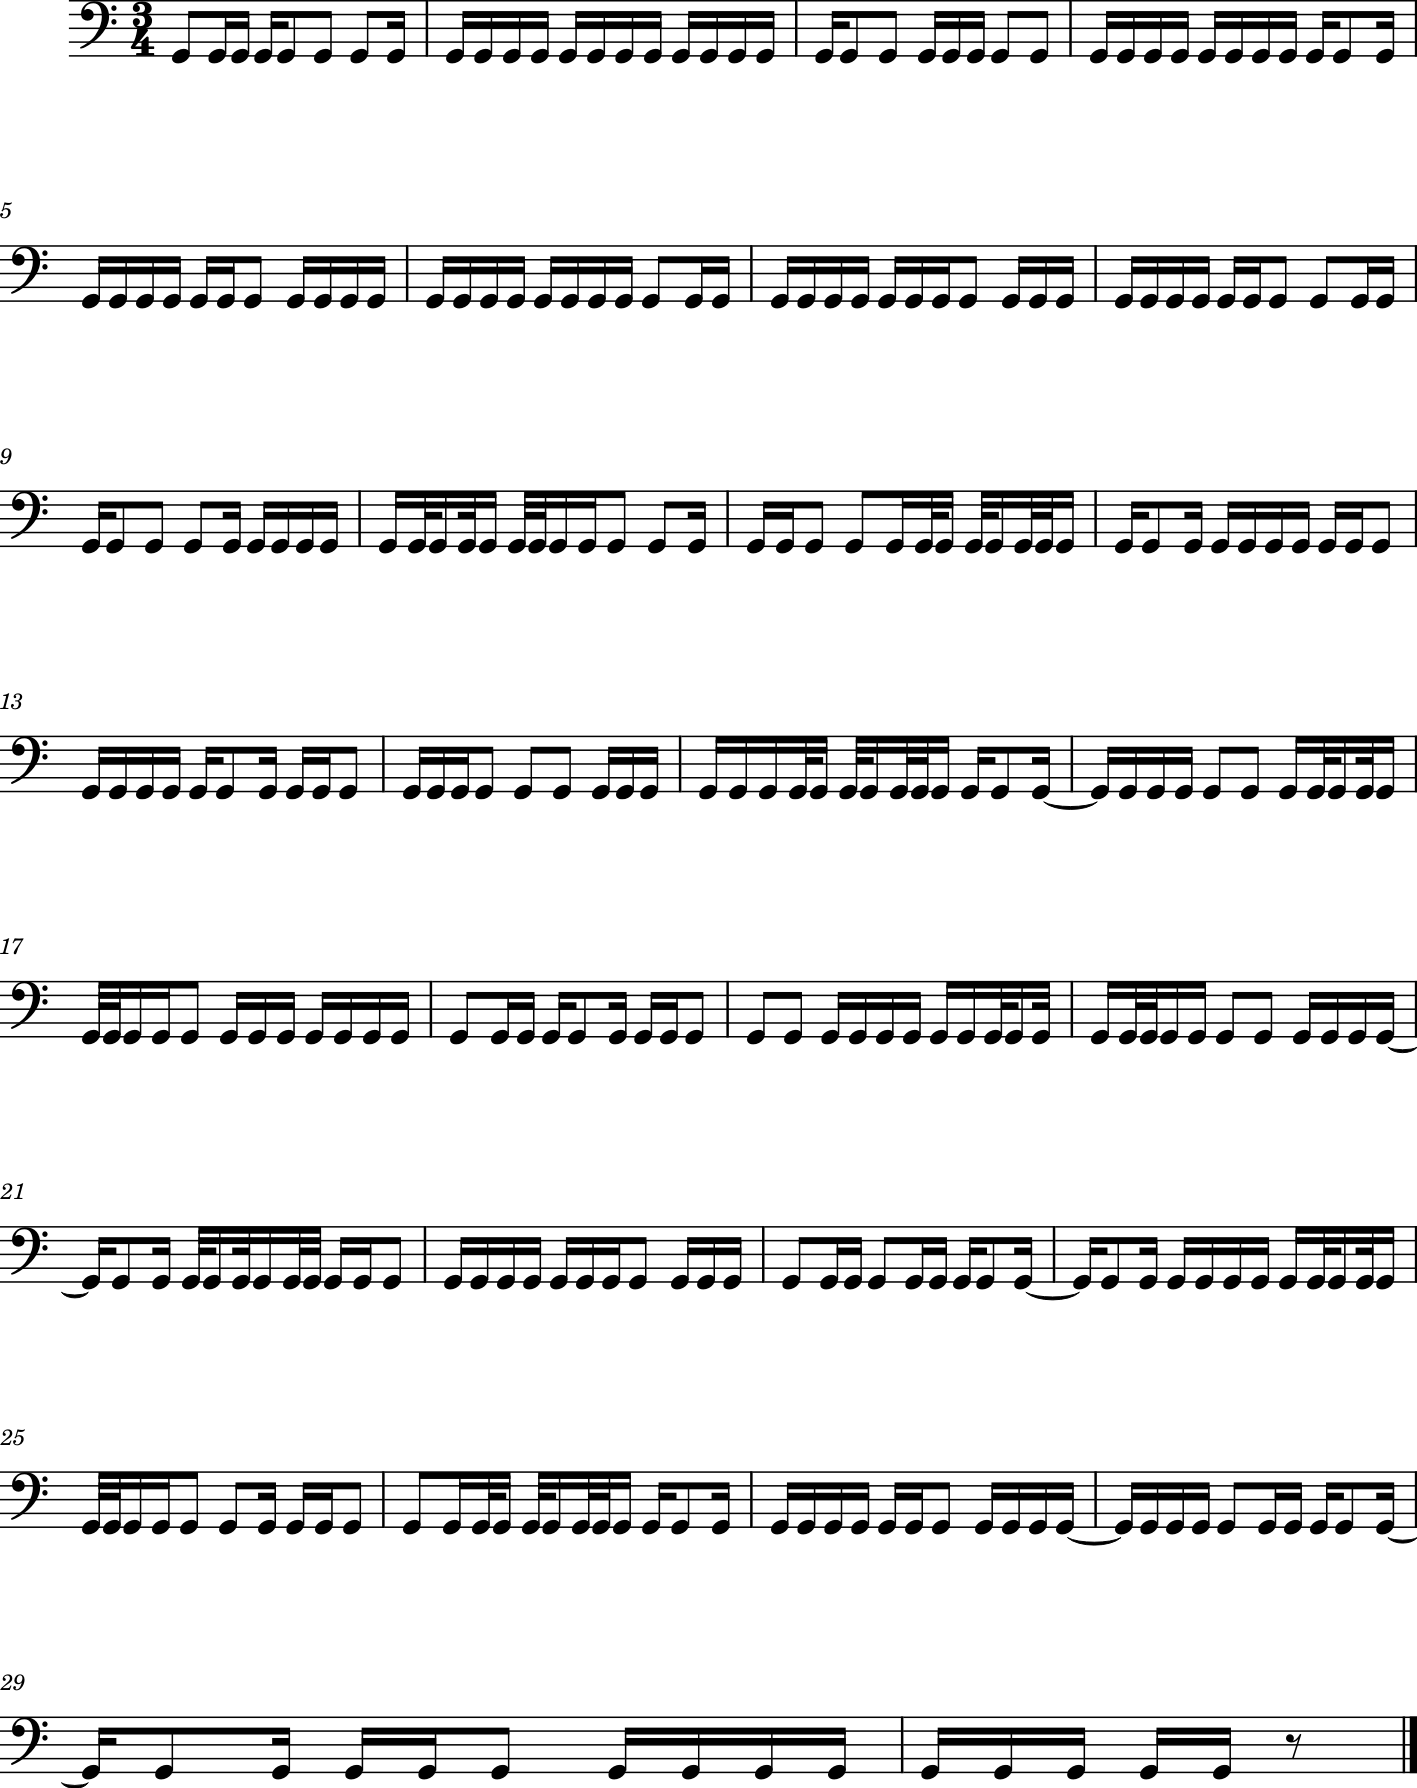

In [18]:
import music21.stream

def combine_voices(length: int, rhythm, *voices, inst=None, time_sig='4/4'):
    """
    Define a voice to be a sequence of integers encoding pitches.
    This function takes multiple voices + an array of note durations (the parameter: rhythm)
    It then superposes all the voices and creates a set of synchronous notes (could be one, two [interval],
    three to nine [chord], or more) and plays these sets consecutively according to the rhythm sequence

    Otherwise said, it adds the same rhythmical durations to each voice, causing them to be superposed

    :param time_sig
    :param inst: list of used instruments
    :param length: common length of voices to consider
    :param rhythm: rhythmic line: sequence of durations
    :param voices: sequences of integers encoding notes
    :return stream of chords
    """

    if inst is None:
        inst = [instrument.Piano()]
    voices = voices[0]
    scoreStream = stream.Score()
    scoreStream.timeSignature = meter.TimeSignature(time_sig)

    parts = [stream.Part() for _ in range(len(voices))]
    for part_index in range(len(voices)):
        parts[part_index].timeSignature = meter.TimeSignature(time_sig)
        for i in range(length):
            parts[part_index].append(translate(voices[part_index][i], rhythm[i]))

    for i in range(len(parts)):
        parts[i].insert(0, inst[i])
        scoreStream.insert(0, parts[i])

    return scoreStream


def combine_melody_rhythm(length: int, voices: music21.stream.Stream, inst=None):
    if inst is None:
        inst = [instrument.Piano() for i in range(length)]
    track = [[] for i in range(len(inst))]
    for i in range(length):
        for j in range(len(inst)):
            track[i].append(voices[i])


if __name__ == "__main__":
    rhythm = sequence_from_string_complex(run_complex_for(4))
    length = int(len(rhythm) / 60)
    print(f"{length} notes kept")
    score = combine_voices(length, rhythm, [[7 for i in range(length)]], inst=None, time_sig="3/4")

    bolero_rhythm = run_bolero_for(3, True)
    print(f"end of the sequence: {bolero_rhythm[-60:]}")

    bolero_rhythm = sequence_from_string_bolero(run_bolero_for(3, False))
    length = int(len(bolero_rhythm))
    bolero_score = combine_voices(length, bolero_rhythm, [[7 for _ in range(length)]], inst=[instrument.Woodblock()],
                                  time_sig="3/4")
    bolero_score.show()
    # play(bolero_score)

Thankfully, *Boléro*'s main rhythm is very easy and repetitive and can be cut down in to 3 parts A, B & C, organised in
the sequence: ABAC. A groups the first 3 sextuplets and the following eighth note, B is a group of 3 sextuplets followed
by 3 eighth notes, and C encompasses 9 sextuplets followed by a final eighth note. After some initial turbulence,
the tail of the produced string becomes several repetitions of the ABAC motives. A, B & C are encoded as ``L-System``
rules in our code, with a twist: instead of sextuplets, sixteenth notes are used in A, turning the *Boléro*'s time
signature into a 7/8. Then, the decision was later made to ease back into the *Boléro*'s 3/4, for reasons stated below.

In [20]:
import math

if __name__ == "__main__":
    bolero_rhythm = sequence_from_string_bolero(run_bolero_for(3, False))
    quarter_length = math.floor(len(bolero_rhythm)/4)
    bolero_rhythm = bolero_rhythm[:quarter_length] + bolero_rhythm[3 * quarter_length:]
    length = int(len(bolero_rhythm))
    bolero_score = combine_voices(length, bolero_rhythm, [[7 for _ in range(length)]], inst=[instrument.Woodblock()],
                                  time_sig="3/4")

    bolero_2_measures = music21.stream.Score()
    part_bolero_2_measures = music21.stream.Part(instrument=instrument.Woodblock(), time_sig="3/4")
    part_bolero_2_measures.append(note.Note(duration=dur.Duration(1/3)))

    # bolero_score.write('midi', 'midi' + platform_str + 'convergence_bolero_sextuplet.mid')

# V) Combining L-System and harmonisation
Generative code:

In [27]:
import math
import music21.stream

def notes_array(tonality, bass, first_chord, length_composition):
    """
    Construct 4 parts
    :param tonality: Desired tonality
    :param bass: Bass line in the tonality
    :param first_chord: First chord in the composition
    :param length_composition
    :return: array of 4 voices of notes
    """
    voices_arrays = [[], [], [], []]
    next_start_chord = first_chord
    for j in range(length_composition):
        next_compos_tree = Node(next_start_chord, 1, [])
        compose(next_start_chord, bass[1:], next_compos_tree, False, tonality)
        path = select_path_in_tree_harm(len(bass), next_compos_tree)
        next_start_chord = path[-1]
        path = to_arrays(path)
        for i in range(4):
            voices_arrays[i].extend(path[i])

    return voices_arrays


def combine_score_and_rhythm(curr_score: music21.stream.Score, curr_rhythm):
    """
    Combine a music21 Score and some rhythmic line
    :param curr_score: Rhythm-less harmonised notes
    :param curr_rhythm: Array of floats expressing durations
    :return: Complete score
    """
    new_score = music21.stream.Score()
    for curr_part in curr_score.parts:
        new_part = music21.stream.Part()
        for i in range(len(curr_part.notes)):
            new_part.append(note.Note(nameWithOctave=curr_part.notes[i].nameWithOctave,
                                      duration=dur.Duration(math.fabs(curr_rhythm[i]))))
        new_score.insert(0, new_part)
    return new_score

if __name__ == "__main__":

    # SEE REPO ON GITHUB FOR MIDI FOLDERS
    
    # voices = converter.parse('midi/input_midis/3_16.mid') 
    # string_res = run_complex_for(4)
    # sequence = sequence_from_string_complex(string_res)
    # instruments = [instrument.Piano(), instrument.Piano(), instrument.Piano(), instrument.Piano()]

    # score_comp = combine_score_and_rhythm(voices, sequence)

    # score_comp.write('midi', 'midi' + platform_str + 'convergence_complexification_complex_kept.mid')
    pass

End of file.